# Monitoraggio Dati COVID-19 Italia

© Copyright 2020, Pietro Di Gangi

Raw data sources:
* COVID-19 data from Dipartimento della Protezione Civile: https://github.com/pcm-dpc/COVID-19
* Population data from  ISTAT (01/01/2019)

In [567]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [568]:
%run init.py

Current time: 2020-04-09 18:46:27.892872


In [569]:
#############################################
# Useful functions
#############################################
def sorted_set(regions, var):
    '''Ordina set rispetto alla variabile var'''
    df = data[data.region.isin(regions)][data.date==lastday].sort_values(var, ascending=False)
    sortedset = df.region.unique()
    return sortedset

def leglabels_style():
    '''Make legend labels colored'''
    leg._legend_box.align = "left"
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())
        
def format_dateaxis():
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()

In [570]:
#############################################
# Read data from github repo: https://github.com/pcm-dpc/COVID-19
# Dipartimento della Protezione Civile
#############################################
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
path = 'dpc-covid19-ita-andamento-nazionale.csv'
ita = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
regioni = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
prov = pd.read_csv(url)

#############################################
# Manipulate dataframes
#############################################
# Italia #################
ita = ita.rename(columns={
    'data': 'date',
    'totale_casi': 'cases',
    'deceduti' : 'deaths',
    'tamponi' : 'tests',
    'dimessi_guariti': 'recovered',
})
ita['region'] = 'Italia'
ita['date'] = ita['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))


# Nord, Centro, Sud #################
nord = ['Lombardia', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Liguria', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Valle d\'Aosta', 'Veneto']
centro = ['Abruzzo', 'Lazio', 'Marche', 'Molise', 'Toscana', 'Umbria']
sud = ['Basilicata', 'Calabria', 'Campania', 'Puglia', 'Sardegna', 'Sicilia']
def zone(region):
    if region in nord:
        return 'Nord'
    elif region in centro:
        return 'Centro'
    elif region in sud:
        return 'Sud'
    else: print('Error: No zone assigned to region!')


# Regioni #################
regioni = regioni.rename(columns={
    'data': 'date',
    'totale_casi': 'cases',
    'deceduti' : 'deaths',
    'denominazione_regione' : 'region',
    'tamponi' : 'tests',
    'dimessi_guariti': 'recovered'
})
regioni['date'] = regioni['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
regioni['zone'] = regioni['region'].map(lambda location: zone(location))
regioni = regioni.sort_values(['region', 'date'])

# Aree (Nord, Centro, Sud) #################
aree = regioni.groupby(['zone', 'date'],as_index=False).sum()
aree['region'] = aree['zone']

# merge dataframes #################
data = ita.append([aree, regioni], ignore_index=True)

# Dati popolazione ISTAT 01/01/2019
population = {
    'Lombardia': 10.04e6,
    'Emilia-Romagna': 4.45e6,
    'Veneto': 4.91e6,
    'Piemonte': 4.38e6,
    'Marche': 1.53e6,
    'Toscana': 3.74e6,
    'Liguria': 1.56e6,
    'Lazio': 5.90e6,
    'Campania': 5.83e6,
    'Friuli Venezia Giulia': 1.22e6,
    'P.A. Trento': 541e3,
    'P.A. Bolzano': 531e3,
    'Puglia': 4.05e6,
    'Abruzzo': 1.32e6,
    'Sicilia': 4999891,
    'Umbria': 885e3,
    'Sardegna': 1.65e6,
    'Valle d\'Aosta': 126e3,
    'Calabria': 1.96e6,
    'Basilicata': 567e3,
    'Molise': 308e3,
    'Nord': 27758000,
    'Centro': 13683000,
    'Sud': 19056891,
    'Italia': 60497891
}
# add population information
for region in population.keys():
    data.at[data.region==region, 'population'] = population[region]
data['population'] = data['population'].replace(np.nan, 9999999999)
data = data.replace(np.nan,0.0000000001)

# add differential data
for col in ['cases', 'recovered', 'deaths','tests','terapia_intensiva','totale_positivi','ricoverati_con_sintomi']:
    data['new_'+col] = data[col].diff()

data['new_terapia_intensiva_netta'] = data['new_terapia_intensiva'] + data['new_deaths'] + data['new_recovered']*data['terapia_intensiva'].shift(1)/data['ricoverati_con_sintomi'].shift(1)    

# add data per 100k inhabitants
for var in ['cases','new_cases','deaths','new_deaths','recovered','new_recovered','tests','new_tests','terapia_intensiva','new_terapia_intensiva','ricoverati_con_sintomi','new_ricoverati_con_sintomi']:
    data[var+'_per100k'] = data.apply(lambda row: row[var]/row.population*1e5, axis = 1)
    
# add tassi d'incremento 
def delta(data, variables):
    '''Tasso di crescita mediato sugli ultimi 1,2,3,4 giorni'''
    for var in variables: 
        for dayspan in [1,2,3,4]:
            colname = var+'_delta'+str(dayspan)
            data[colname] = 0
            for i in np.arange(dayspan):
                data[colname] = data[colname] + data['new_'+var].shift(i)/data[var].shift(i+1)
            data[colname] = data[colname]/dayspan    
    return data
data = delta(data, ['cases', 'deaths', 'recovered', 'tests'])

# cast some columns to int
data = data.replace(np.nan,0.0000000000)
data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population','tests','new_tests','terapia_intensiva','new_terapia_intensiva']] = data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population','tests','new_tests','terapia_intensiva','new_terapia_intensiva']].astype(int)

# ordering and casting/formatting columns   
data = data[['date','region','cases','new_cases','deaths','new_deaths','recovered','new_recovered','population',
             'tests','new_tests','terapia_intensiva','new_terapia_intensiva','new_terapia_intensiva_netta','totale_ospedalizzati','ricoverati_con_sintomi','new_ricoverati_con_sintomi','isolamento_domiciliare','totale_positivi','new_totale_positivi',
             'cases_per100k','new_cases_per100k','deaths_per100k','new_deaths_per100k','recovered_per100k','new_recovered_per100k',
             'tests_per100k','new_tests_per100k','terapia_intensiva_per100k','new_terapia_intensiva_per100k','ricoverati_con_sintomi_per100k','new_ricoverati_con_sintomi_per100k',
             'cases_delta1','cases_delta2','cases_delta3','cases_delta4',
             'deaths_delta1','deaths_delta2','deaths_delta3','deaths_delta4',
             'recovered_delta1','recovered_delta2','recovered_delta3','recovered_delta4',
             'tests_delta1','tests_delta2','tests_delta3','tests_delta4',
            ]]

data.to_pickle('dataframes/mydata_dpc_ita.p')

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# Tabella Dati Nazionali e Regionali

In [571]:
lastday = data.date.iat[-1]
print('Dati aggiornati a:', lastday)

summary = data[data.date==lastday].sort_values('cases', ascending=False)
summary = summary[['region','cases','new_cases','deaths','new_deaths','terapia_intensiva','cases_per100k','deaths_per100k']]
summary['cases_per100k'] = summary['cases_per100k'].map('{:.1f}'.format)
summary['deaths_per100k'] = summary['deaths_per100k'].map('{:.1f}'.format)
summary.head(30)

Dati aggiornati a: 2020-04-09 17:00:00


region   cases  new_cases  deaths  new_deaths  \
45                   Italia  143626       4204   18279         610   
137                    Nord  113732       3380   15961         528   
597               Lombardia   54802       1388   10022         300   
91                   Centro   19399        521    1588          58   
413          Emilia-Romagna   18677        443    2316          82   
827                Piemonte   14522        639    1454          76   
1149                 Veneto   12933        523     756          20   
183                     Sud   10495        303     730          24   
1011                Toscana    6552        173     408          16   
551                 Liguria    5020        114     682          28   
643                  Marche    4955         96     669          17   
505                   Lazio    4429        163     253           9   
367                Campania    3344         76     227           6   
873                  Puglia    2716         82     225           6   
781             P.A. Trento    2708        106     268          13   
459   Friuli Venezia Giulia    2299         81     171           2   
965                 Sicilia    2232         73     138           5   
229                 Abruzzo    1931         72     194          15   
735            P.A. Bolzano    1903         68     187           4   
1057                 Umbria    1298          9      51           1   
919                Sardegna    1026         51      64           5   
321                Calabria     874         15      61           1   
1103          Valle d'Aosta     868         18     105           3   
275              Basilicata     303          6      15           1   
689                  Molise     234          8      13           0   

      terapia_intensiva cases_per100k deaths_per100k  
45                 3605         237.4           30.2  
137                2619         409.7           57.5  
597                1236         545.8           99.8  
91                  686         141.8           11.6  
413                 355         419.7           52.0  
827                 412         331.6           33.2  
1149                274         263.4           15.4  
183                 300          55.1            3.8  
1011                256         175.2           10.9  
551                 154         321.8           43.7  
643                 133         323.9           43.7  
505                 198          75.1            4.3  
367                  94          57.4            3.9  
873                  86          67.1            5.6  
781                  69         500.6           49.5  
459                  37         188.4           14.0  
965                  63          44.6            2.8  
229                  57         146.3           14.7  
735                  64         358.4           35.2  
1057                 38         146.7            5.8  
919                  25          62.2            3.9  
321                  15          44.6            3.1  
1103                 18         688.9           83.3  
275                  17          53.4            2.6  
689                   4          76.0            4.2

# 1D Diagnostic Plots
Andamento delle singole variabili relative ai casi COVID-19 tramite grafici 1D.

## Valori normalizzati su popolazione: dati cumulati
Totale casi COVID-19 confermati per 100000 abitanti in Italia (Nord, Centro e Sud)
* Bars: i contributi delle singole aree sono sovrapposti

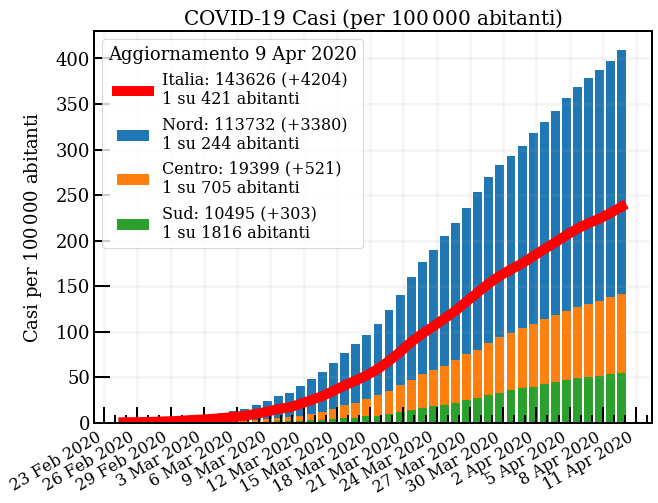

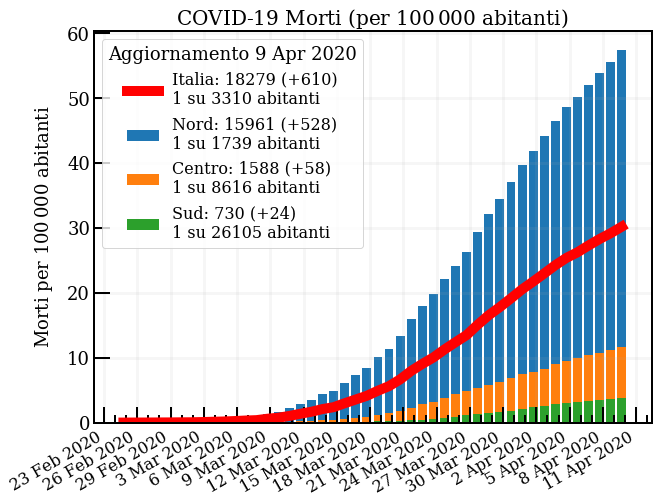

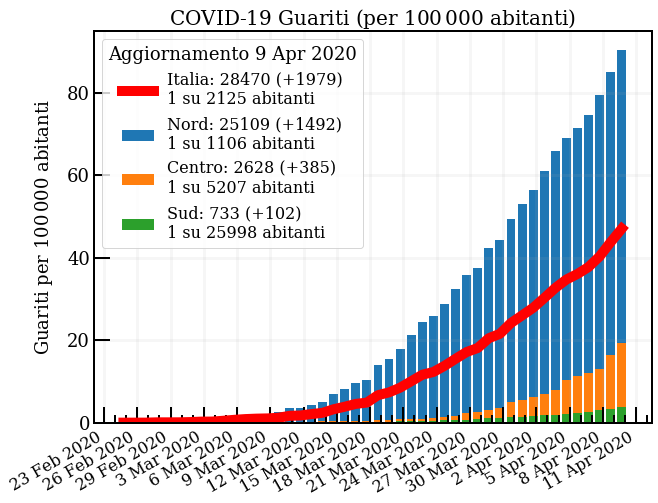

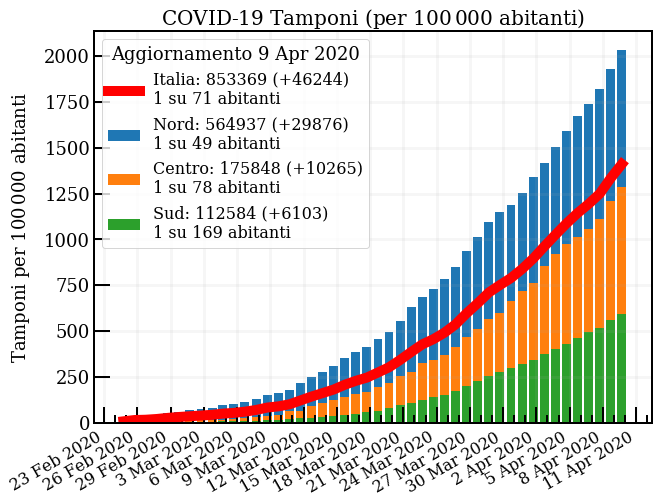

In [572]:
def cumulative_normalized(regions, var, title='', ylabel='y'):

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    N = len(regions)
    
    # plot data
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df['population'].iat[0]        
        tot = df[var].iat[-1]
        lb = '%s: %d (+%.f)' % (reg, tot, df['new_'+var].iat[-1])
        lb = lb + '\n1 su %.f abitanti' % (pop/tot)
        if reg=='Italia':
            ax.plot(df.date, df[var]/pop*1e5, label=lb, color='r', lw=10, ls='-')
        else:
            ax.bar(df.date, df[var]/pop*1e5, label=lb)

    # axes settings
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    

regions = ['Nord', 'Centro', 'Sud','Italia']
cumulative_normalized(regions, 'cases', title='COVID-19 Casi (per 100$\,$000 abitanti)', ylabel='Casi per 100$\,$000 abitanti')
cumulative_normalized(regions, 'deaths', title='COVID-19 Morti (per 100$\,$000 abitanti)', ylabel='Morti per 100$\,$000 abitanti')
cumulative_normalized(regions, 'recovered', title='COVID-19 Guariti (per 100$\,$000 abitanti)', ylabel='Guariti per 100$\,$000 abitanti')
cumulative_normalized(regions, 'tests', title='COVID-19 Tamponi (per 100$\,$000 abitanti)', ylabel='Tamponi per 100$\,$000 abitanti')

## Valori normalizzati su popolazione: dati differenziali
Nuovi casi giornalieri COVID-19 per 100000 abitanti in Italia (Nord, Centro e Sud)

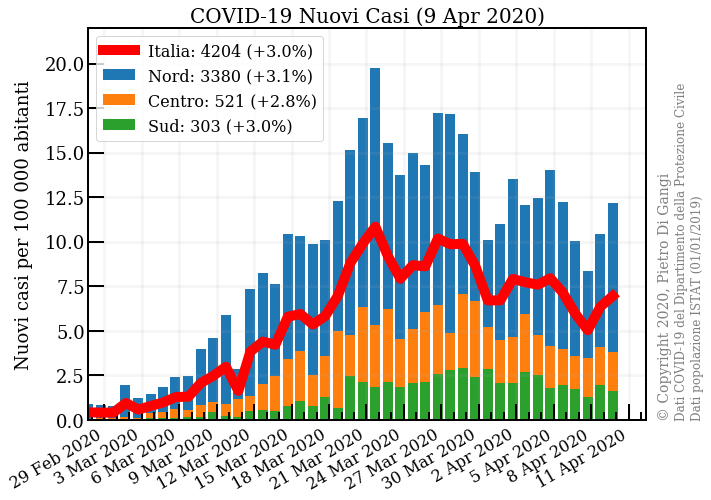

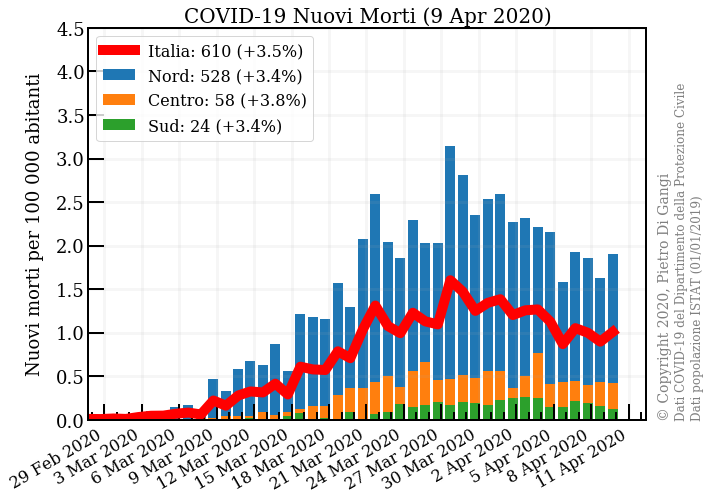

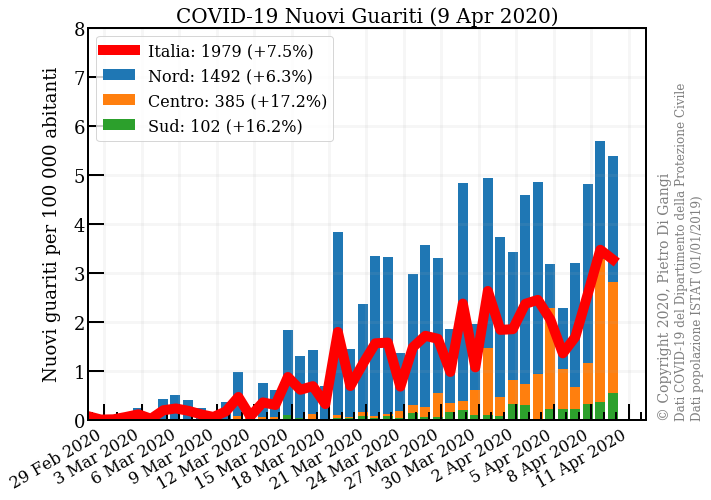

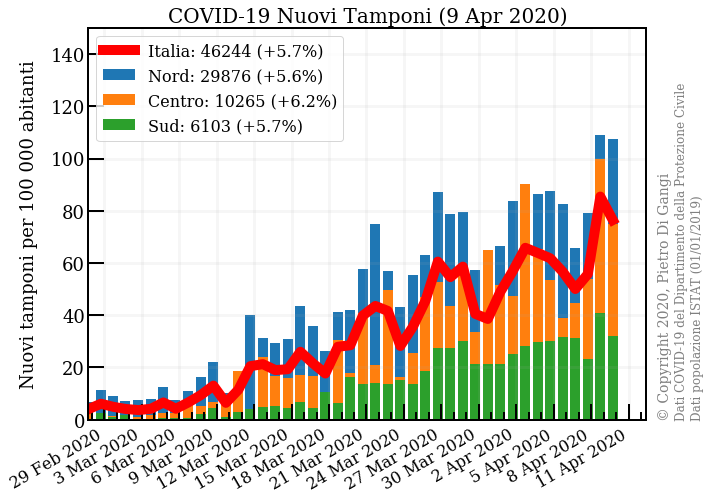

In [589]:
def differential_normalized(regions, var, title='', ylabel='y per 100 000 abitanti', ymax=100):
    cumvar = var.replace("new_", "")

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    N = len(regions)
    
    # plot data
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df['population'].iat[0]        
        tot = df[var].iat[-1]
        lb = '%s: %.f (+%.1f%s)' % (reg, tot, df[cumvar+'_delta1'].iat[-1]*100, '%')
        if reg=='Italia':
            ax.plot(df.date, df[var]/pop*1e5, label=lb, color='r', lw=10, ls='-')
        else:
            ax.bar(df.date, df[var]/pop*1e5, label=lb)

    # axes settings
    ax.set_xlim(left = df.date.iat[3])
    ax.set_ylim(0, ymax)
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16) 
    plt.title(title + ' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)
    
    # disclaimer
    dayspan = df.date.iat[-1] - df.date.iat[0]
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(lastday+0.08*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14)
    text = 'Dati COVID-19 del Dipartimento della Protezione Civile'
    plt.text(lastday+0.11*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    text = 'Dati popolazione ISTAT (01/01/2019)'
    plt.text(lastday+0.14*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)

    
    plt.show()
    

regions = ['Nord', 'Centro', 'Sud','Italia']
differential_normalized(regions, 'new_cases', 
                                  title = 'COVID-19 Nuovi Casi', 
                                  ylabel = 'Nuovi casi per 100 000 abitanti',
                                  ymax = 22
                                 )

differential_normalized(regions, 'new_deaths', 
                                  title = 'COVID-19 Nuovi Morti', 
                                  ylabel = 'Nuovi morti per 100 000 abitanti',
                                  ymax = 4.5
                                 )

differential_normalized(regions, 'new_recovered', 
                                  title = 'COVID-19 Nuovi Guariti', 
                                  ylabel = 'Nuovi guariti per 100 000 abitanti',
                                  ymax = 8
                                 )

differential_normalized(regions, 'new_tests', 
                                  title = 'COVID-19 Nuovi Tamponi', 
                                  ylabel = 'Nuovi tamponi per 100 000 abitanti',
                                  ymax = 150
                                 )

## Valori assoluti: dati cumulati
Numero assoluto di casi COVID-19 confermati in Italia (Nord, Centro e Sud)
* Casi confermati
* Morti
* Guariti
* Tamponi effettuati

**Tipologia grafico**: Stacked bars - I contributi delle diverse aree sono impilati uno sopra l'altro

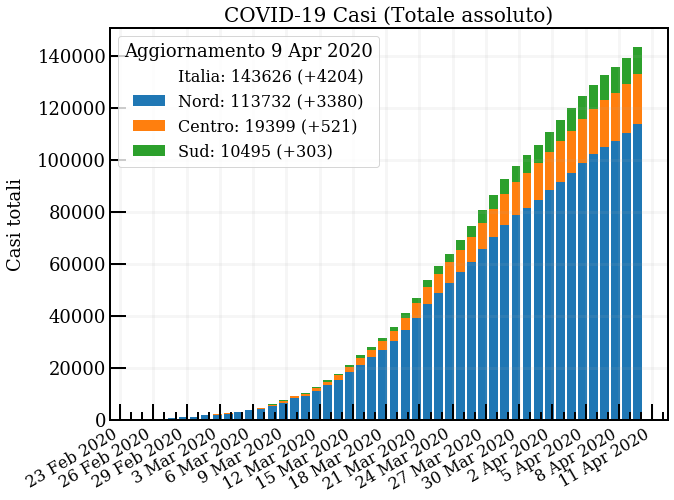

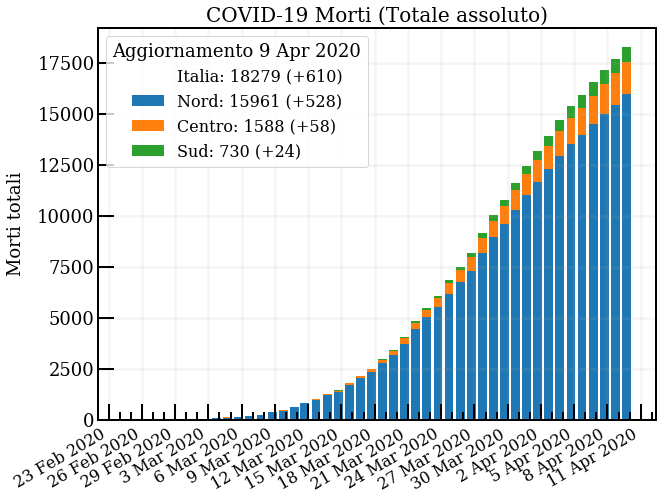

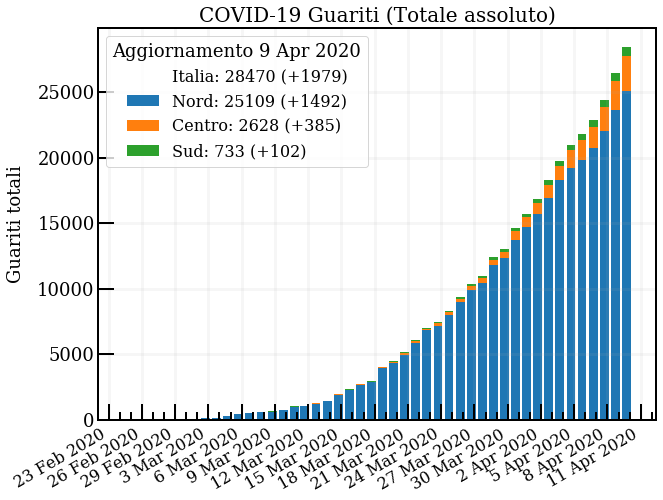

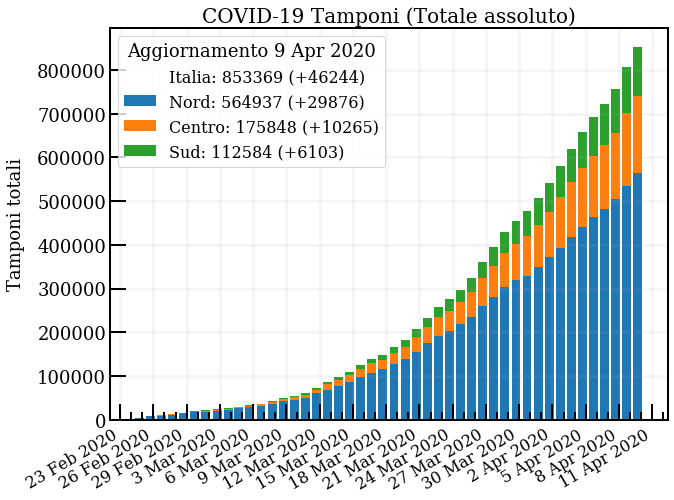

In [574]:
def cumulative(regions, colors, var, title='', ylabel='y'):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    regions = ['Nord', 'Centro', 'Sud']
    colors = ['tab:blue', "tab:orange","tab:green"]
    N = len(regions)

    df = data[data.region==regions[0]]
    margin_bottom = np.zeros(len(df['date'].drop_duplicates()))
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        tot = df[var].iat[-1]
        lb = '%s: %d (+%.f)' % (reg, tot, df['new_'+var].iat[-1])

        values = list(df[var])
        ax.bar(df.date, df[var], bottom=margin_bottom, label=lb)
        margin_bottom += values
    
    df = data[data.region=='Italia']
    lb = 'Italia: %d (+%.f)' % (df[var].iat[-1], df['new_'+var].iat[-1])
    ax.plot(df.date, df[var], label=lb, color='r', lw=5, ls='-', alpha=0)
    
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    
regions = ['Nord', 'Centro', 'Sud']
colors = ['tab:blue', "tab:orange","tab:green"]    
cumulative(regions, colors, 'cases', title='COVID-19 Casi (Totale assoluto)', ylabel='Casi totali')
cumulative(regions, colors, 'deaths', title='COVID-19 Morti (Totale assoluto)', ylabel='Morti totali')
cumulative(regions, colors, 'recovered', title='COVID-19 Guariti (Totale assoluto)', ylabel='Guariti totali')
cumulative(regions, colors, 'tests', title='COVID-19 Tamponi (Totale assoluto)', ylabel='Tamponi totali')

## Valori assoluti: dati differenziali
Variazione assoluta giornaliera di casi COVID-19 in Italia (Nord, Centro e Sud).
* Stacked bars: i contributi delle diverse aree sono impilati uno sopra l'altro

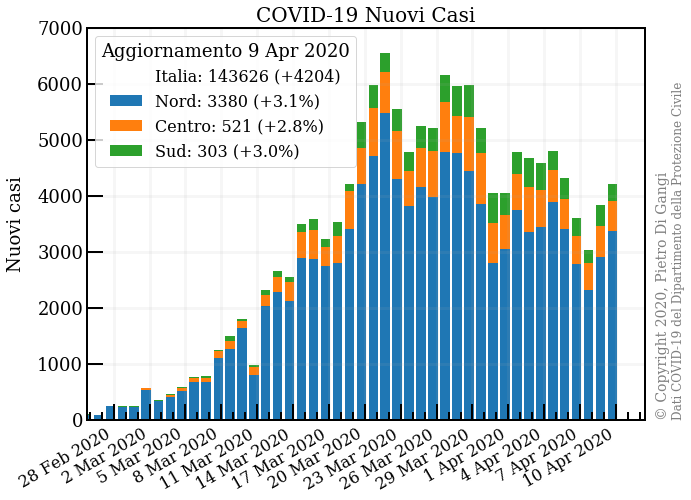

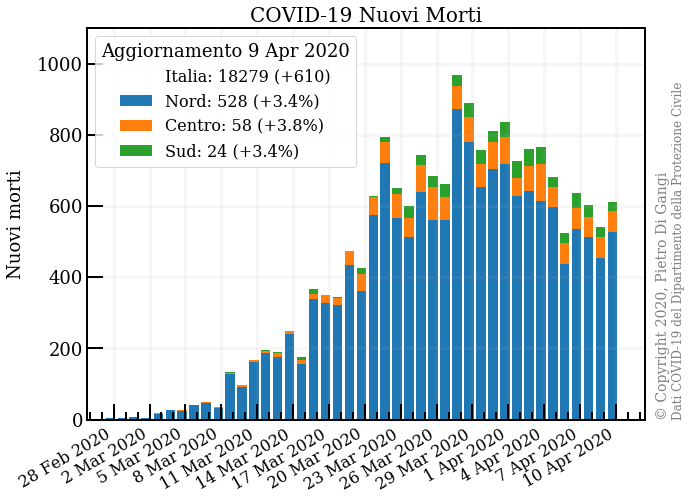

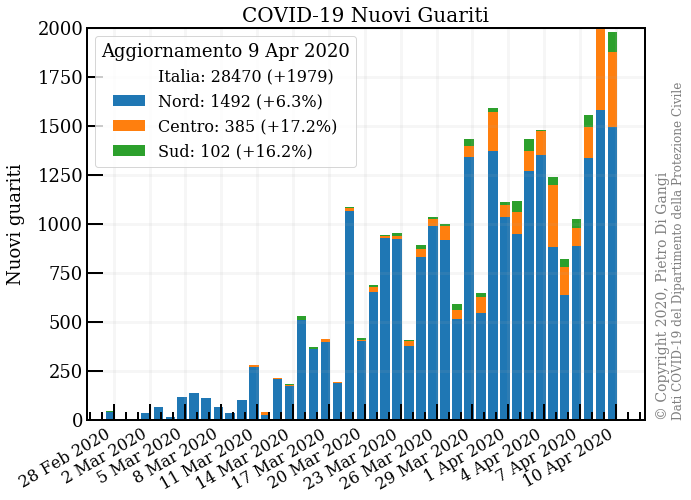

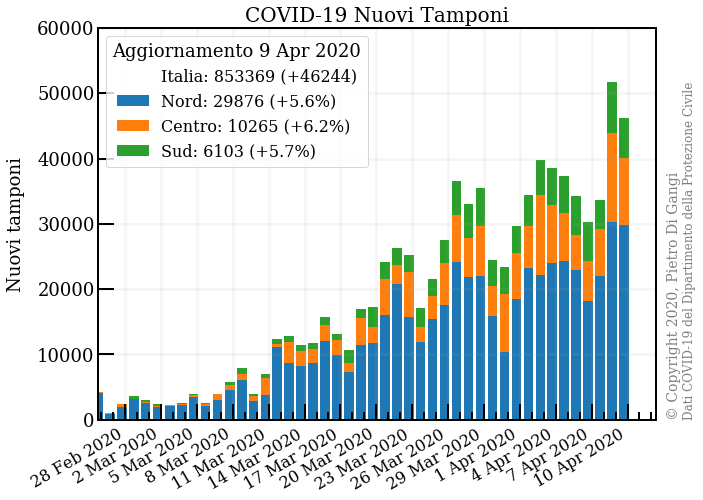

In [575]:
def differential(regions, var, title='', ylabel='y', ymax=100):
    cumvar = var.replace("new_", "")

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    N = len(regions)    
    
    # plot data
    df = data[data.region==regions[0]]
    margin_bottom = np.zeros(len(df['date'].drop_duplicates()))
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        tot = df[var].iat[-1]
        lb = '%s: %.f (+%.1f%s)' % (reg, tot, df[cumvar+'_delta1'].iat[-1]*100, '%')
        
        values = list(df[var])
        ax.bar(df.date, df[var], bottom=margin_bottom, label=lb)
        margin_bottom += values
    
    df = data[data.region=='Italia']
    lb = 'Italia: %d (+%.f)' % (df[cumvar].iat[-1], df[var].iat[-1])
    ax.plot(df.date, df[var], label=lb, color='r', lw=5, ls='-', alpha=0)

    # axes settings
    ax.set_xlim(left = df.date.iat[1])
    ax.set_ylim(0,ymax)
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    # disclaimer
    dayspan = df.date.iat[-1] - df.date.iat[0]
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(lastday+0.08*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14)
    text = 'Dati COVID-19 del Dipartimento della Protezione Civile'
    plt.text(lastday+0.11*dayspan, 0, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    
    plt.show()
    
regions = ['Nord', 'Centro', 'Sud']    
differential(regions, 'new_cases', 
                                  title = 'COVID-19 Nuovi Casi', 
                                  ylabel = 'Nuovi casi',
                                  ymax = 7000
                                 )

differential(regions, 'new_deaths', 
                                  title = 'COVID-19 Nuovi Morti', 
                                  ylabel = 'Nuovi morti',
                                  ymax = 1100
                                 )

differential(regions, 'new_recovered', 
                                  title = 'COVID-19 Nuovi Guariti', 
                                  ylabel = 'Nuovi guariti',
                                  ymax = 2000
                                 )

differential(regions, 'new_tests', 
                                  title = 'COVID-19 Nuovi Tamponi', 
                                  ylabel = 'Nuovi tamponi',
                                  ymax = 60000
                                 )

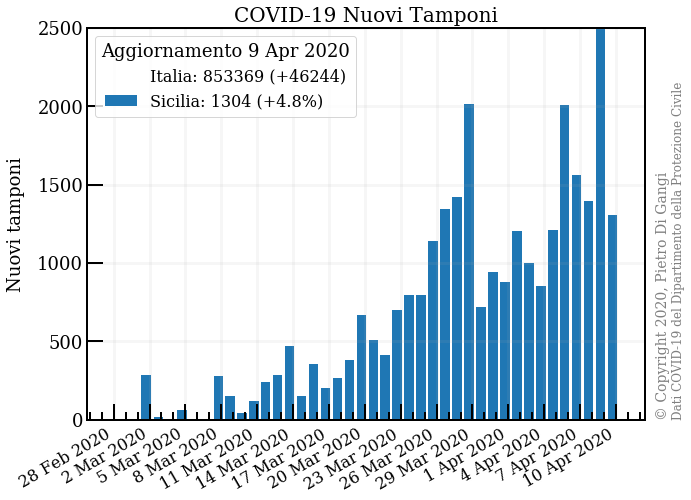

In [576]:
differential(['Sicilia'], 'new_tests', 
                                  title = 'COVID-19 Nuovi Tamponi', 
                                  ylabel = 'Nuovi tamponi',
                                  ymax = 2500
                                 )

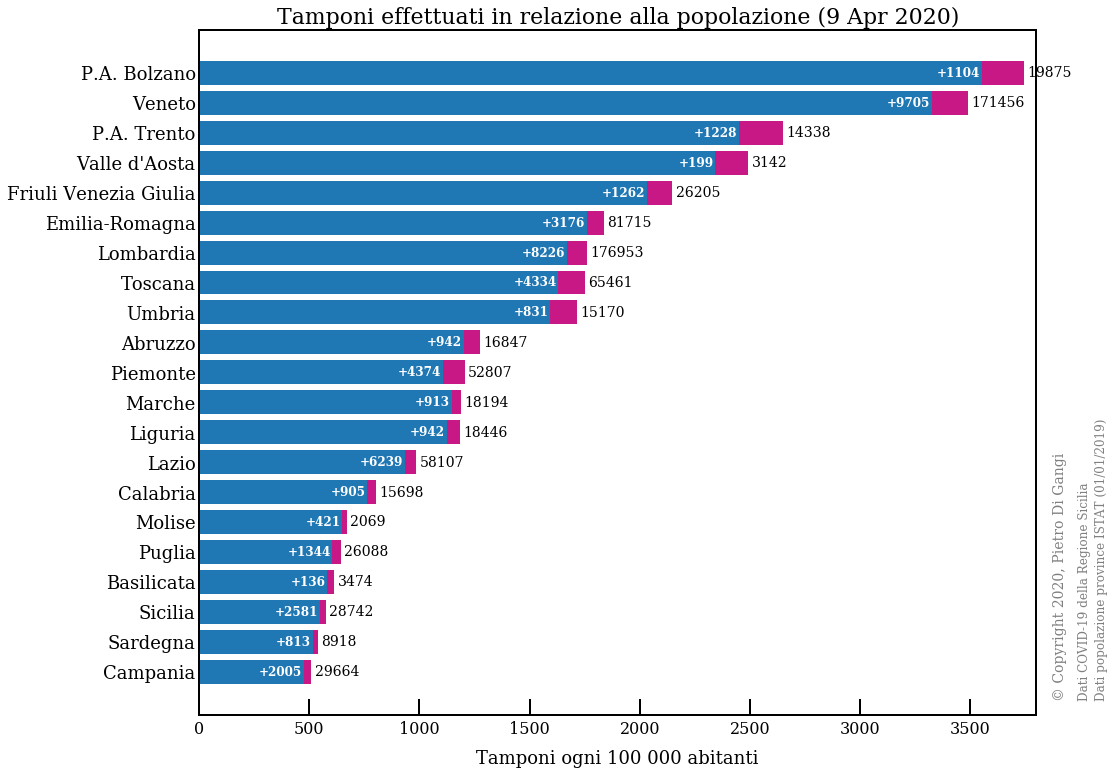

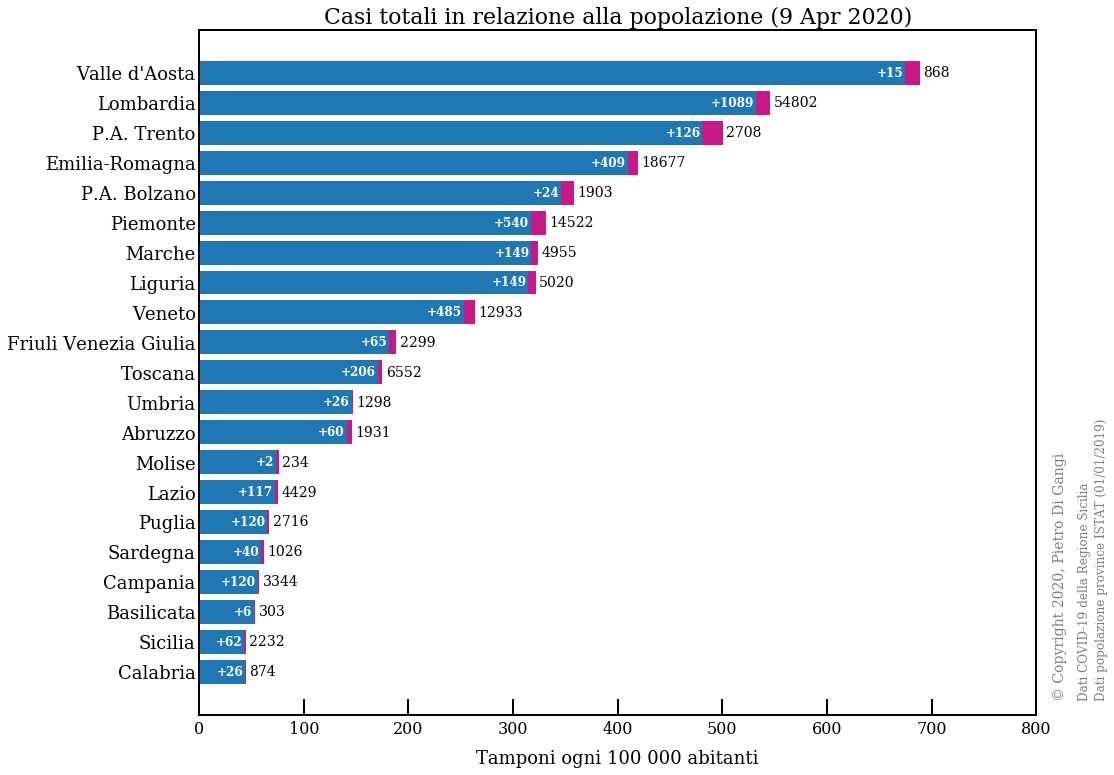

In [577]:
def standing_normalized(states, var, title='', xlabel='x', xmax=100):

    n = len(states)*0.1
    
    fig = plt.figure(figsize=(15,6*n))
    ax = fig.add_subplot(111)
    ax.tick_params(left=False) 
    #states = sorted_states(states, var+'_per100k')
    states = states[::-1]
    
    for i,state in enumerate(states):
        df = data[data.region==state]
        pop = data.population.iat[0]
        tot = df[var].iat[-1]
        ax.barh(state, df[var+'_per100k'].iat[-1], color='mediumvioletred', label='', alpha=0.99)
        for days in np.arange(1):
            ax.barh(state, df[var+'_per100k'].iat[-2-days], color='tab:blue', label='', alpha=1)
        lb = '%d' % (tot)
        ax.text(df[var+'_per100k'].iat[-1]+2*xmax/500, state, lb, ha='left', va='center', fontsize=14)
        ax.text(df[var+'_per100k'].iat[-2]-1*xmax/500, state, ('+%d' % df['new_'+var].iat[-2]), ha='right', va='center', color='w', fontsize=12, weight='bold')
    
    plt.xlabel(xlabel)
    #ax.grid(axis='x', linewidth=2, alpha=0.1, which='major')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.set_xlim(0,xmax)
    
    #legend
    plt.title(title+' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=22)
    
     # disclaimer
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(xmax+0.02*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14)
    text = 'Dati COVID-19 della Regione Sicilia'
    plt.text(xmax+0.05*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    text = 'Dati popolazione province ISTAT (01/01/2019)'
    plt.text(xmax+0.07*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)

    plt.show()
    
    #fig.savefig('figure/%s-covid19-sicilia-contagi-normalizzati.png' % lastday.strftime('%Y-%m-%d'))
       
    
states = data[(data.region.isin(nord+centro+sud))&(data.date==lastday)].sort_values('tests_per100k', ascending=False).region.unique()
standing_normalized(states, 'tests', 'Tamponi effettuati in relazione alla popolazione', 'Tamponi ogni 100 000 abitanti', xmax=3800)


states = data[(data.region.isin(nord+centro+sud))&(data.date==lastday)].sort_values('cases_per100k', ascending=False).region.unique()
standing_normalized(states, 'cases', 'Casi totali in relazione alla popolazione', 'Tamponi ogni 100 000 abitanti', xmax=800)

#states = data[(data.population>1e6)&(data.date==lastday)].sort_values('deaths_per100k', ascending=False).head(20).region.unique()
#standing_normalized(states, 'deaths', 'COVID-19 Deaths | World Top 20', 'Deaths per 100 000 inhabitants', xmax=40)

# Overview COVID-19
Dati cumulati (valore accumulato fino ad oggi):
* Tamponi effettuati
* Casi confermati
* Dimessi guariti
* Morti

Dati attuali (valore registrato oggi):
* Attualmente positivi
* Ospedalizzati
* Ricoverati con sintomi
* In isolamento domiciliare
* In terapia intensiva

## Italia
Andamento e valori complessivi in Italia (Nord, Centro, Sud)

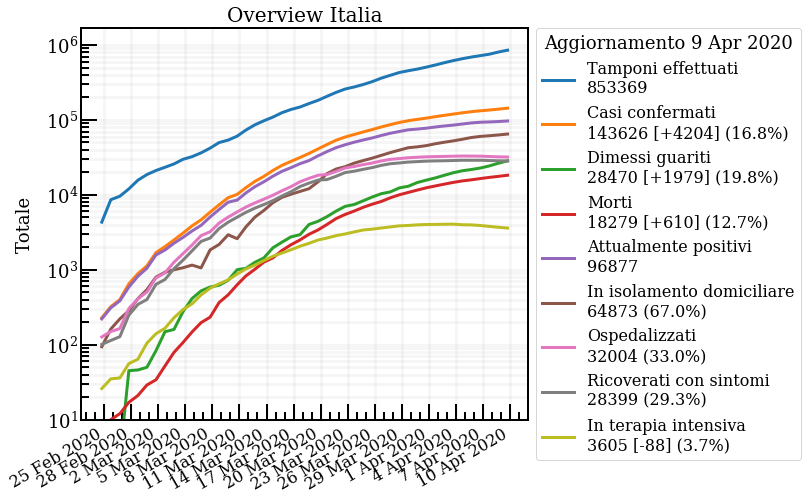

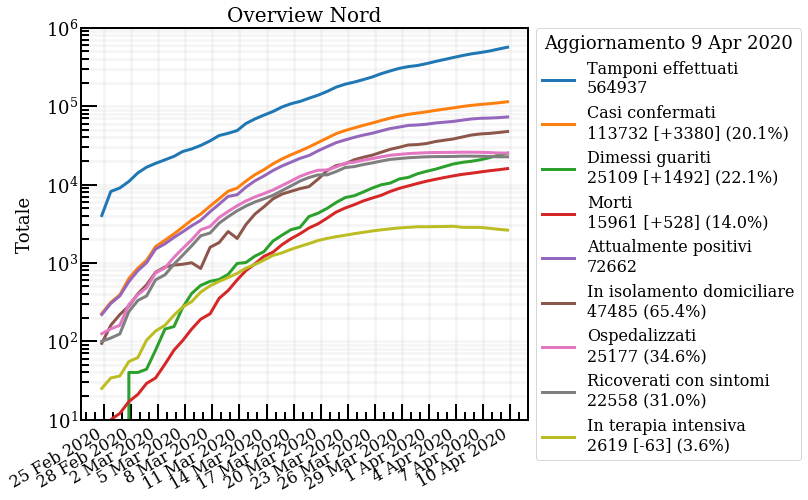

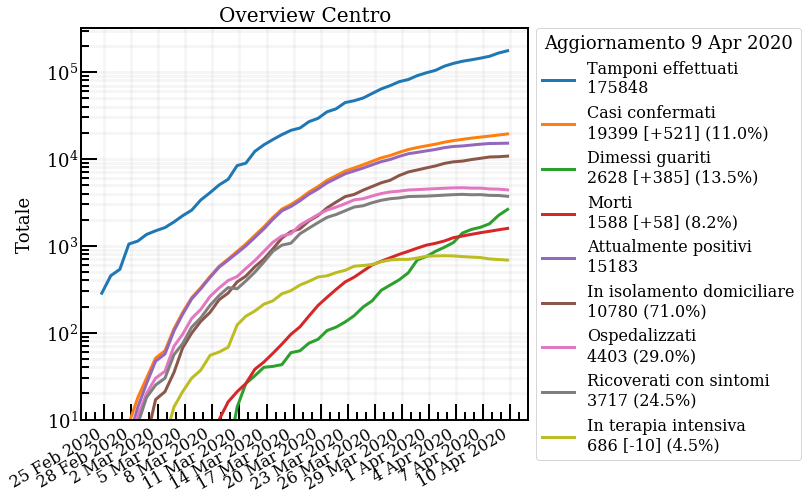

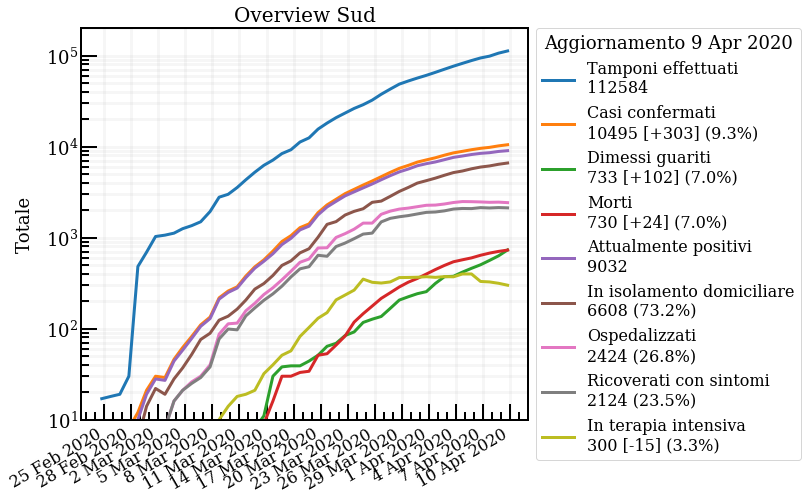

In [578]:
def overview(region, title=''):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
   
    df = data[data.region==region]
    # dati cumulati
    ax.plot(df.date, df.tests, label='Tamponi effettuati\n%d' % df.tests.iat[-1])
    lb = 'Casi confermati\n%d [+%.f]' % (df.cases.iat[-1], df.new_cases.iat[-1])
    lb = lb + ' (%.1f%s)' % (df.cases.iat[-1]/df.tests.iat[-1]*100, '%')
    ax.plot(df.date, df.cases, label=lb)
    lb = 'Dimessi guariti\n%d [+%.f]' % (df.recovered.iat[-1], df.new_recovered.iat[-1])
    lb = lb + ' (%.1f%s)' % (df.recovered.iat[-1]/df.cases.iat[-1]*100, '%')
    ax.plot(df.date, df.recovered, label=lb)
    lb = 'Morti\n%d [+%.f]' % (df.deaths.iat[-1], df.new_deaths.iat[-1])
    lb = lb + ' (%.1f%s)' % (df.deaths.iat[-1]/df.cases.iat[-1]*100, '%')
    ax.plot(df.date, df.deaths, label=lb)
    
    # dati attuali
    ax.plot(df.date, df.totale_positivi, label='Attualmente positivi\n%d' % df.totale_positivi.iat[-1])
    tot = df.isolamento_domiciliare.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    ax.plot(df.date, df.isolamento_domiciliare, label='In isolamento domiciliare\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = df.totale_ospedalizzati.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    ax.plot(df.date, df.totale_ospedalizzati, label='Ospedalizzati\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = df.ricoverati_con_sintomi.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    ax.plot(df.date, df.ricoverati_con_sintomi, label='Ricoverati con sintomi\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = df.terapia_intensiva.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    new = df.new_terapia_intensiva.iat[-1]
    ax.plot(df.date, df.terapia_intensiva, label='In terapia intensiva\n%d [%.f] (%.1f%s)' % (tot, new, pc*100, '%'))
    
    plt.ylabel('Totale')
    plt.yscale('log')
    ax.set_ylim(bottom=10)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, bbox_to_anchor=(1.,1.02), title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    

regions = ['Nord', 'Centro', 'Sud']
overview('Italia', 'Overview Italia')
for area in ['Nord', 'Centro', 'Sud']:
    overview(area, 'Overview '+area)

## Evoluzione giornaliera della situazione ospedaliera
Aumento giornaliero di:
* Casi confermati
* Morti
* Dimessi guariti
* Nuovi ricoveri in terapia intensiva (TI) *

Variazione giornaliera di:
* Persone attualmente positive
* Persone ricoverate in ospedale
* Persone ricoverate in terapia intensiva

(*) I nuovi ingressi giornalieri in terapia intensiva sono stimati sulla base della variazione di posti di TI attualmente occupati, morti e guariti. In questo modo si tiene conto dei posti di TI liberati ogni giorno, stimati sotto le seguenti assunzioni:
* Posto di TI liberato per morte - I morti di oggi si trovavano in terapia intensiva il giorno precedente
* Posto di TI liberato per guarigione - Fra i dimessi guariti di oggi, una frazione uguale a ricoveri_terapia_intensiva/ricoveri (riscontrata il giorno precedente) era ricoverata in terapia intensiva


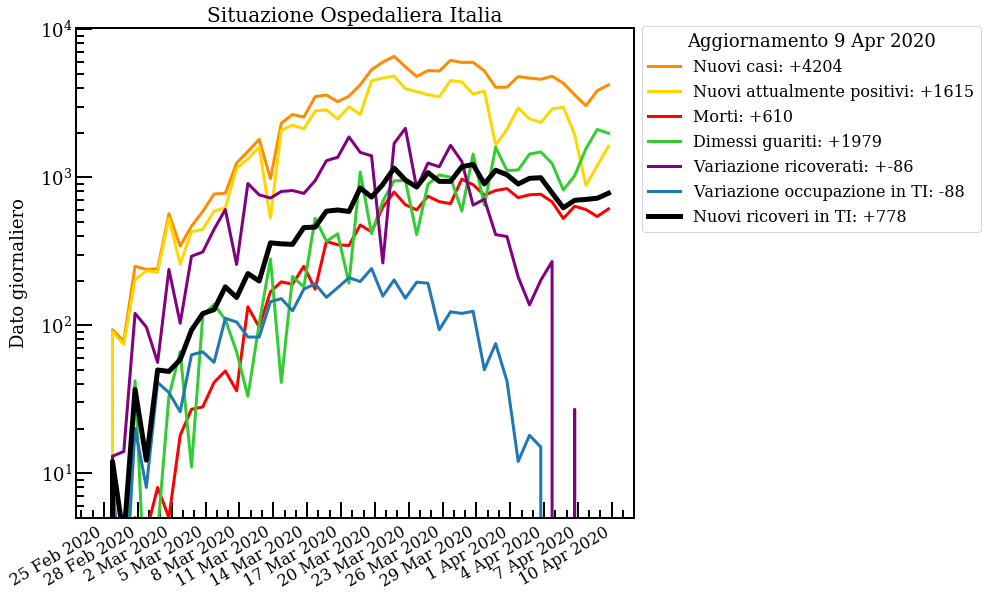

In [579]:
def malati(region, title=''):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
   
    df = data[data.region==region]
    
    ax.plot(df.date, df.new_cases, color='darkorange', label='Nuovi casi: +%d' % df.new_cases.iat[-1])
    ax.plot(df.date, df.new_totale_positivi, color='gold', label='Nuovi attualmente positivi: +%d' % df.new_totale_positivi.iat[-1])
    ax.plot(df.date, df.new_deaths, color='r', label='Morti: +%d' % df.new_deaths.iat[-1])
    ax.plot(df.date, df.new_recovered, color='limegreen', label='Dimessi guariti: +%d' % df.new_recovered.iat[-1])
    ax.plot(df.date, df.new_ricoverati_con_sintomi, color='purple', label='Variazione ricoverati: +%d' % df.new_ricoverati_con_sintomi.iat[-1])
    if df.new_terapia_intensiva.iat[-1]<0: sign=''
    else: sign='+'
    ax.plot(df.date, df.new_terapia_intensiva, color='tab:blue', label='Variazione occupazione in TI: %s%d' % (sign,df.new_terapia_intensiva.iat[-1]))
    ax.plot(df.date, df.new_terapia_intensiva_netta, lw=5, ls='-', color='k', label='Nuovi ricoveri in TI: +%d' % df.new_terapia_intensiva_netta.iat[-1])

    
    plt.ylabel('Dato giornaliero')
    plt.yscale('log')
    ax.set_ylim(bottom=5)
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left', bbox_to_anchor=(1,1.02), fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    

malati('Italia', 'Situazione Ospedaliera Italia')

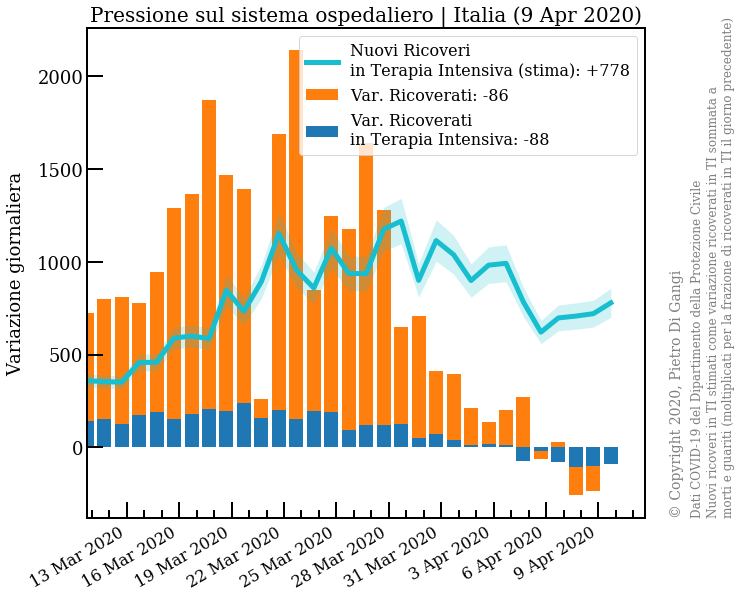

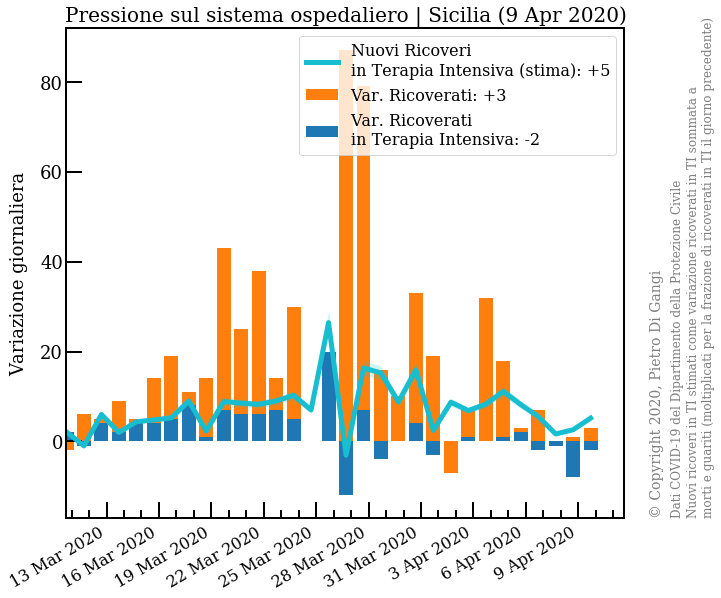

In [580]:
def icu(region, title='', dayspan=30):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
   
    df = data[data.region==region]
    df = df[df.date > lastday-timedelta(dayspan)]
    
    #ax.plot(df.date, df.new_cases, color='darkorange', label='Nuovi casi: +%d' % df.new_cases.iat[-1])
    #ax.plot(df.date, df.new_totale_positivi, color='gold', label='Nuovi attualmente positivi: +%d' % df.new_totale_positivi.iat[-1])
    #ax.plot(df.date, df.new_deaths, color='r', label='Morti: +%d' % df.new_deaths.iat[-1])
    #ax.plot(df.date, df.new_recovered, color='limegreen', label='Dimessi guariti: +%d' % df.new_recovered.iat[-1])
    if df.new_ricoverati_con_sintomi.iat[-1]<0: sign=''
    else: sign='+'
    ax.bar(df.date, df.new_ricoverati_con_sintomi, color='tab:orange', label='Var. Ricoverati: %s%d' % (sign,df.new_ricoverati_con_sintomi.iat[-1]))
        
    if df.new_terapia_intensiva.iat[-1]<0: sign=''
    else: sign='+'
    ax.bar(df.date, df.new_terapia_intensiva, color='tab:blue', label='Var. Ricoverati\nin Terapia Intensiva: %s%d' % (sign,df.new_terapia_intensiva.iat[-1]))

    ax.plot(df.date, df.new_terapia_intensiva_netta, color='tab:cyan', lw=5, label='Nuovi Ricoveri\nin Terapia Intensiva (stima): +%d' % df.new_terapia_intensiva_netta.iat[-1])
    ax.fill_between(df.date, df.new_terapia_intensiva_netta*1.1, df.new_terapia_intensiva_netta, lw=0, alpha=0.2, color='tab:cyan', zorder=100)
    ax.fill_between(df.date, df.new_terapia_intensiva_netta*0.9, df.new_terapia_intensiva_netta, lw=0, alpha=0.2, color='tab:cyan', zorder=100)

    
    plt.ylabel('Variazione giornaliera')
    #plt.yscale('log')
    ax.set_ylim()
    ax.set_xlim(left=lastday-timedelta(days=dayspan))
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc=0, fontsize=16) 
    plt.title(title + ' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)
    
    # disclaimer
    xlim = timedelta(days=dayspan)
    ylim = ax.get_ylim()
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(lastday+timedelta(1)+0.08*xlim, ylim[0], text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14)
    text = 'Dati COVID-19 del Dipartimento della Protezione Civile'
    plt.text(lastday+timedelta(1)+0.12*xlim, ylim[0], text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    text = 'Nuovi ricoveri in TI stimati come variazione ricoverati in TI sommata a\nmorti e guariti (moltiplicati per la frazione di ricoverati in TI il giorno precedente)'
    plt.text(lastday+timedelta(1)+0.15*xlim, ylim[0], text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)

    plt.show()
    

icu('Italia', 'Pressione sul sistema ospedaliero | Italia')

icu('Sicilia', 'Pressione sul sistema ospedaliero | Sicilia')

## Regioni
Andamento e valori complessivi nelle singole regioni

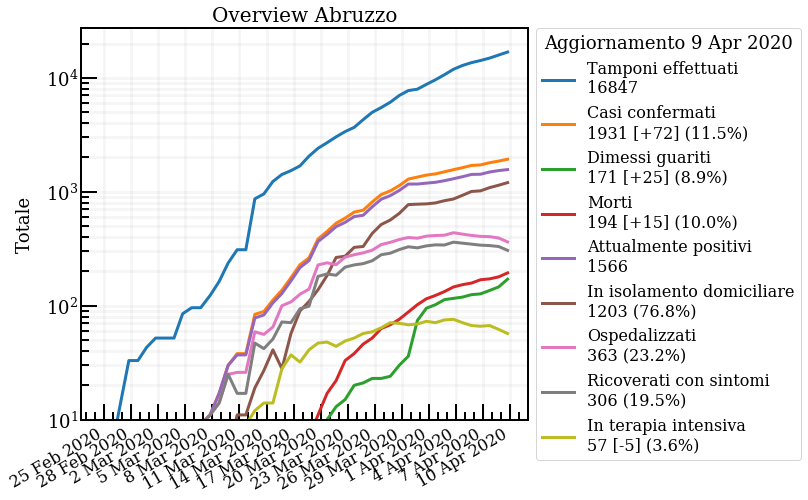

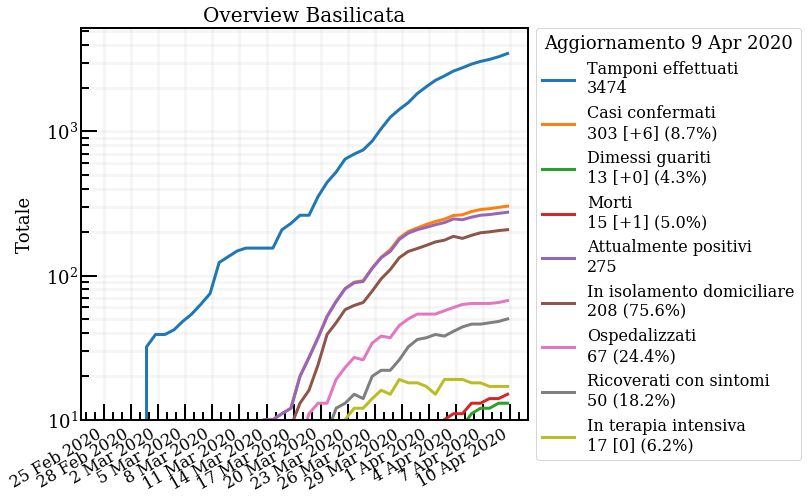

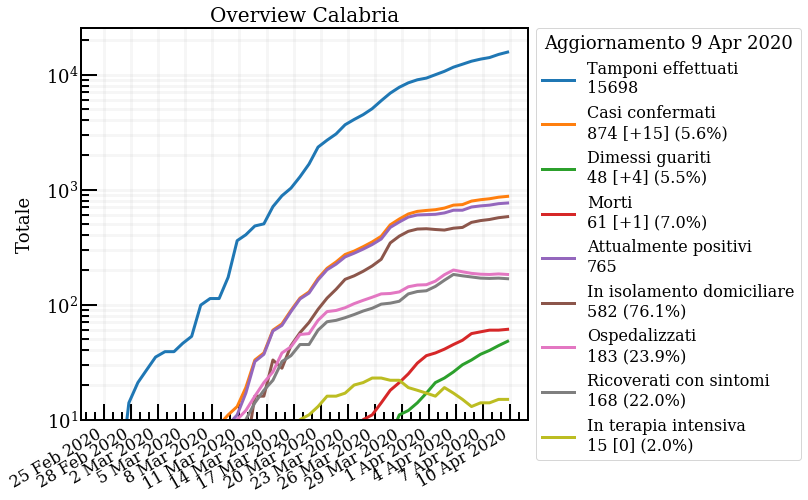

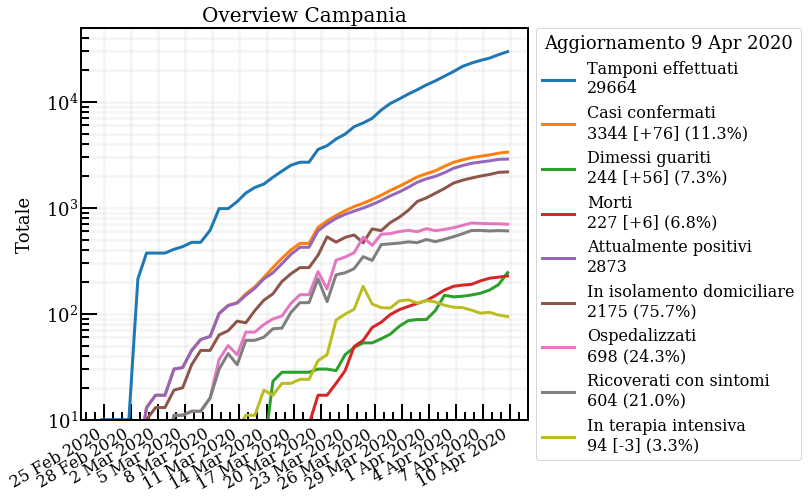

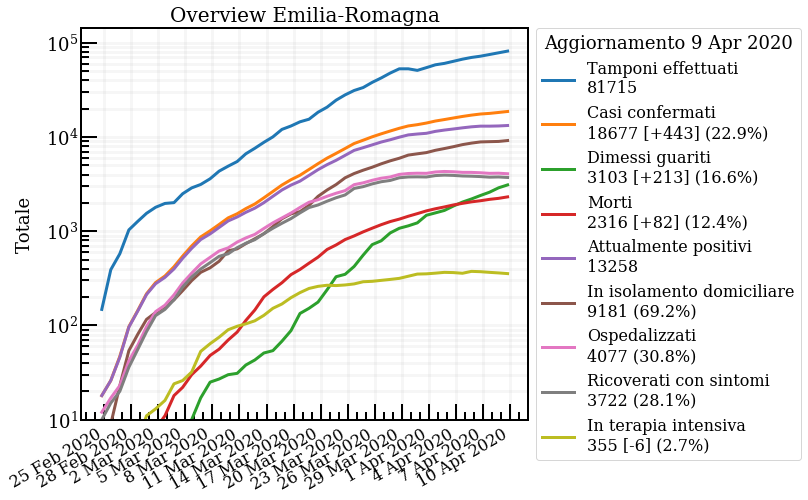

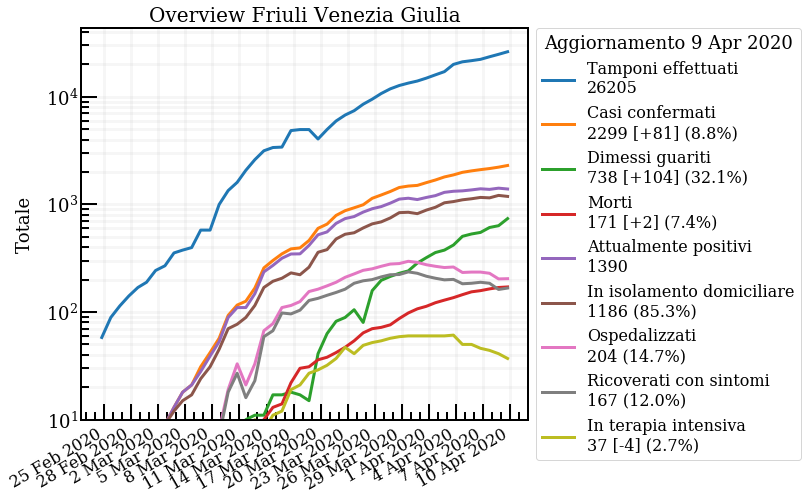

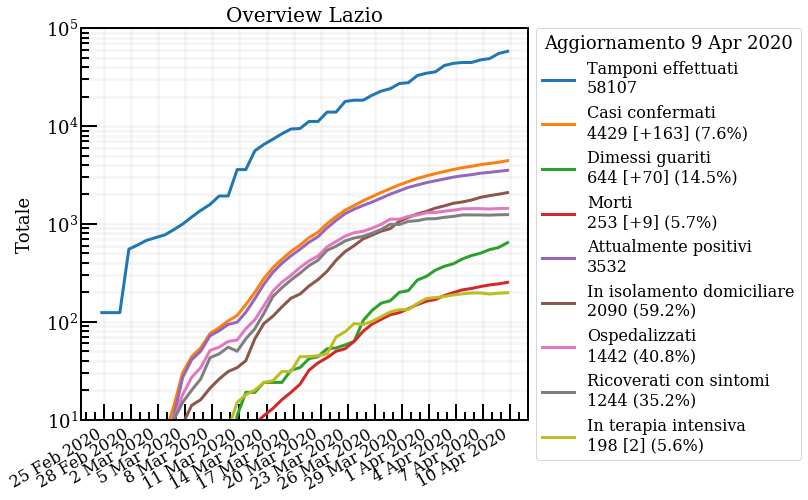

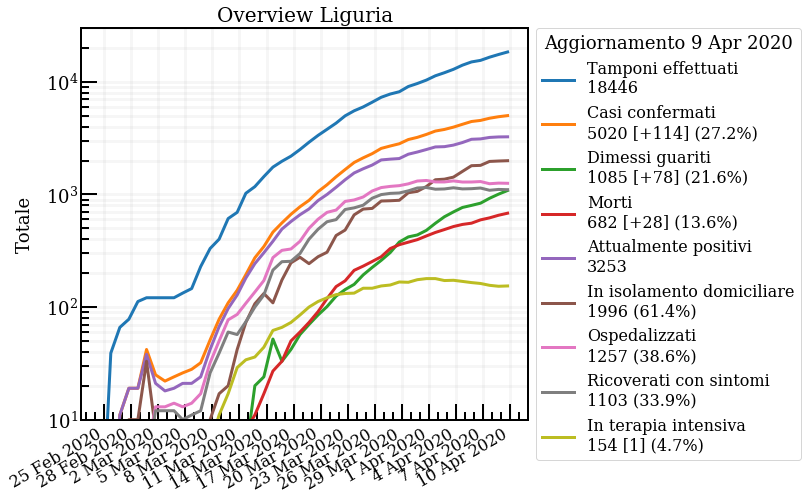

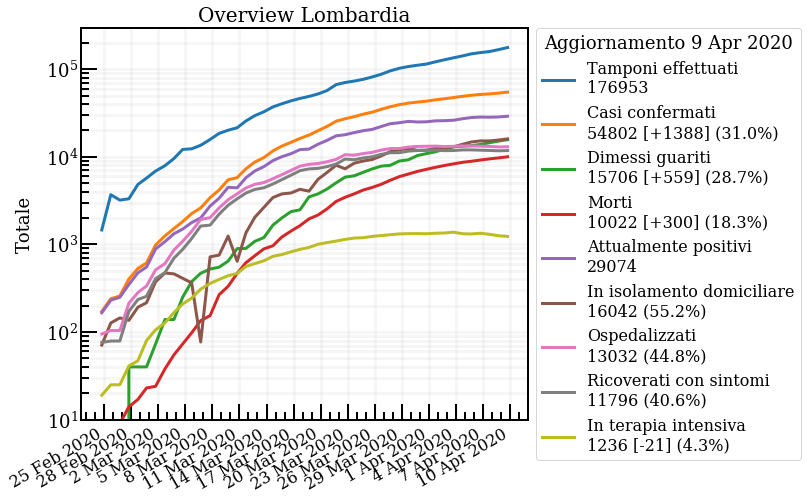

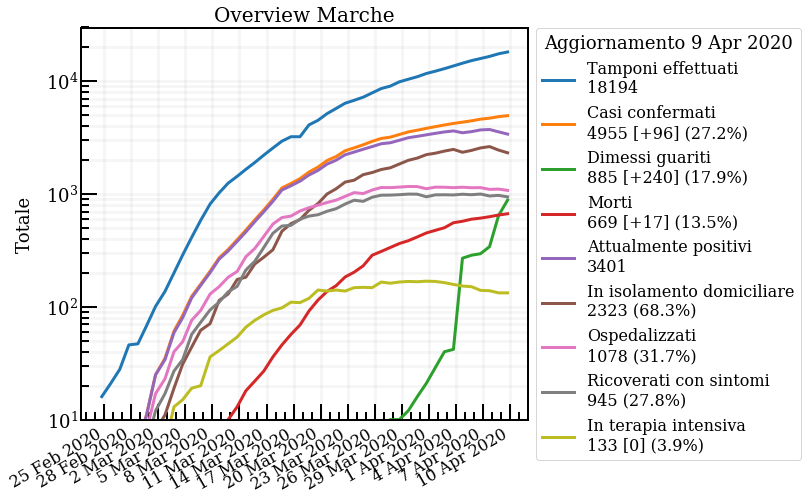

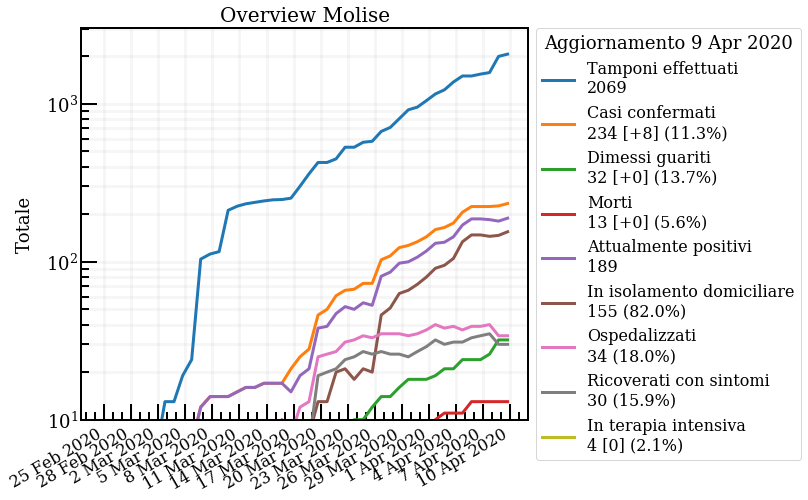

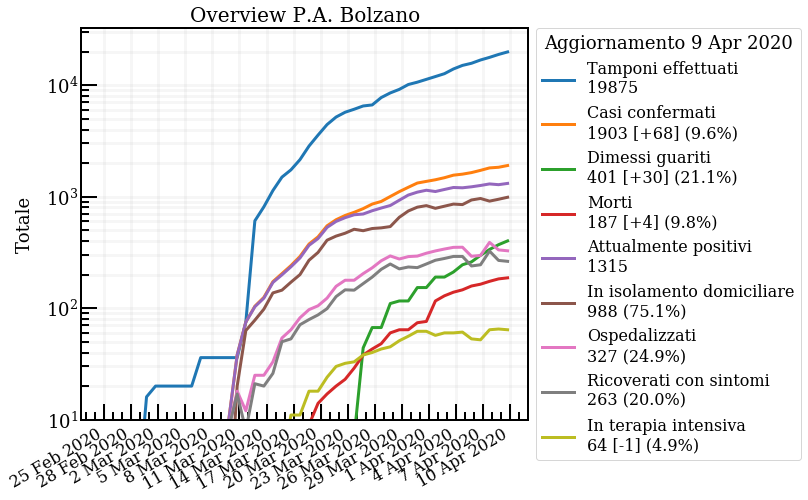

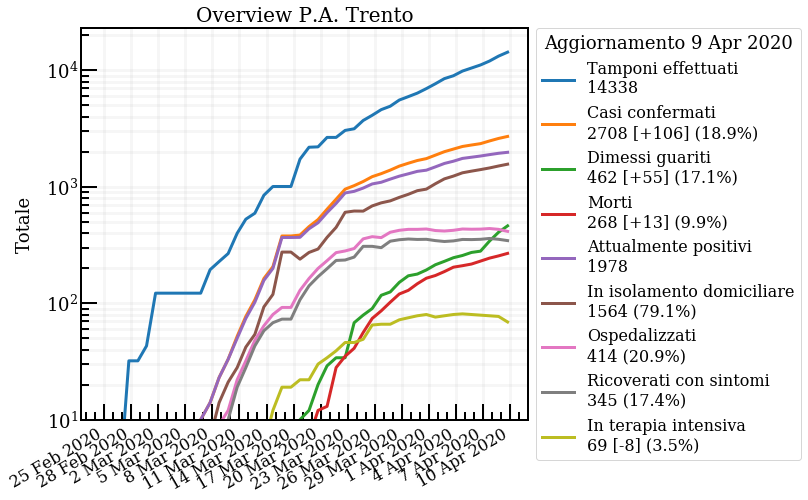

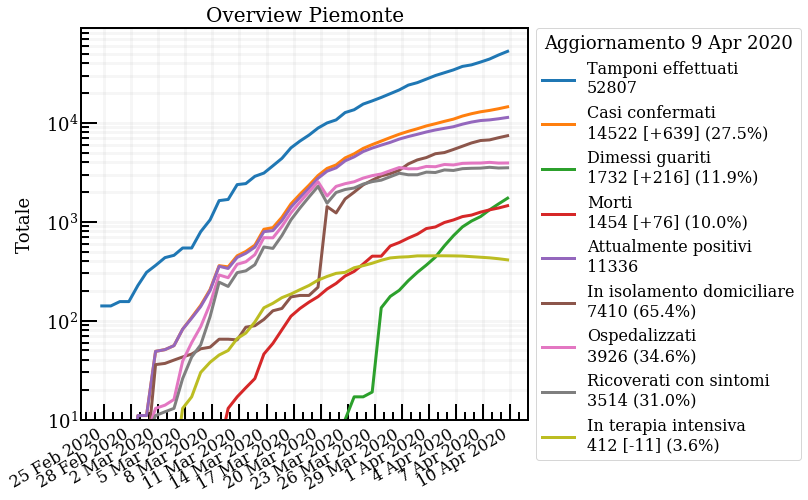

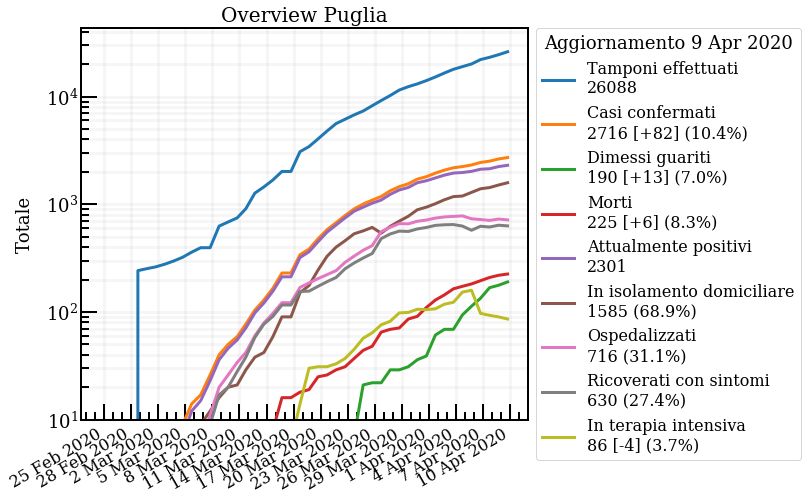

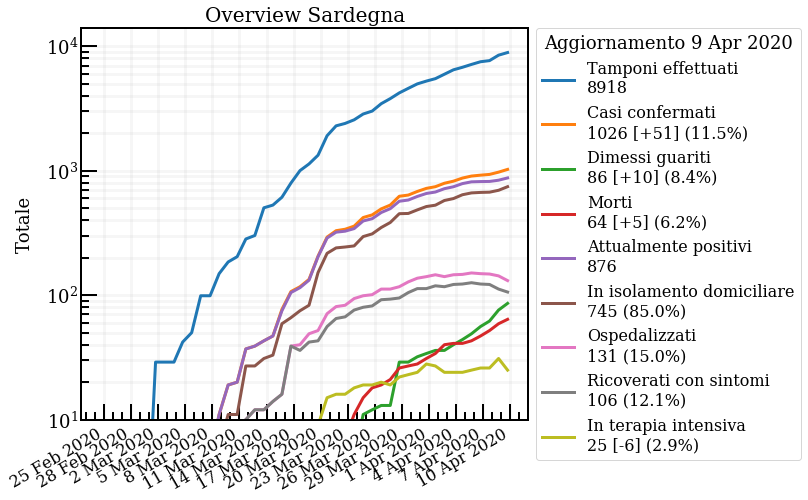

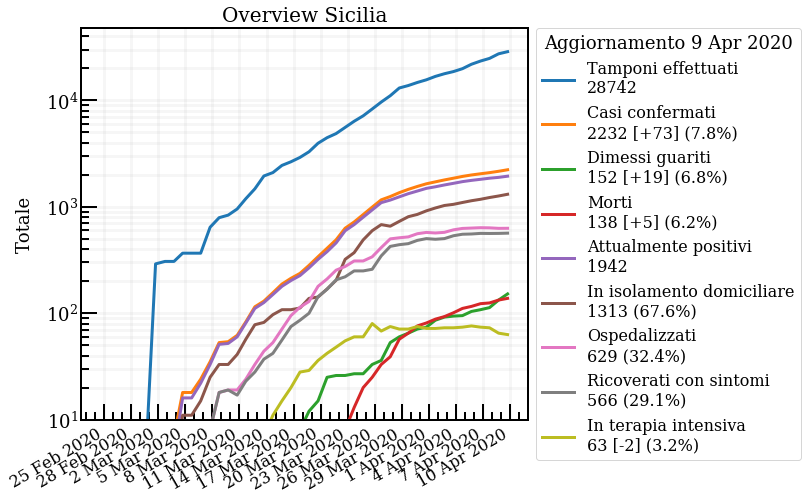

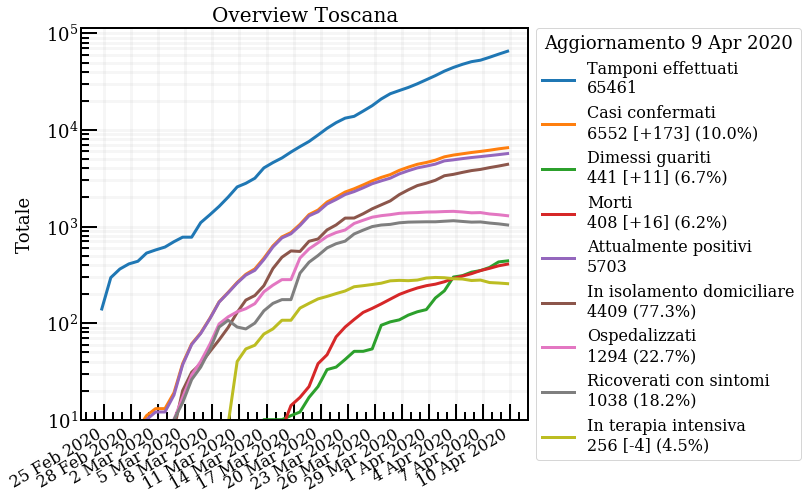

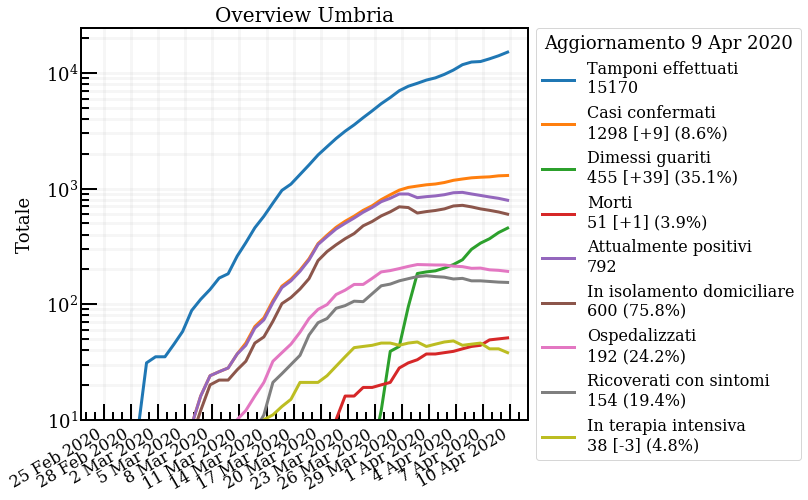

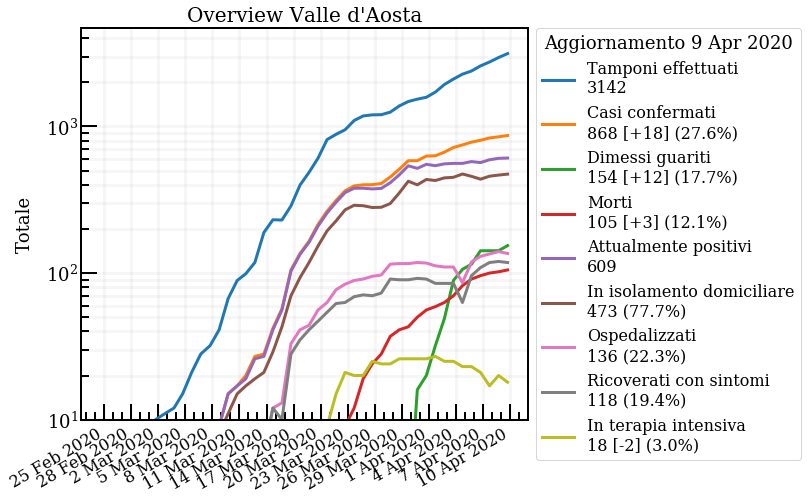

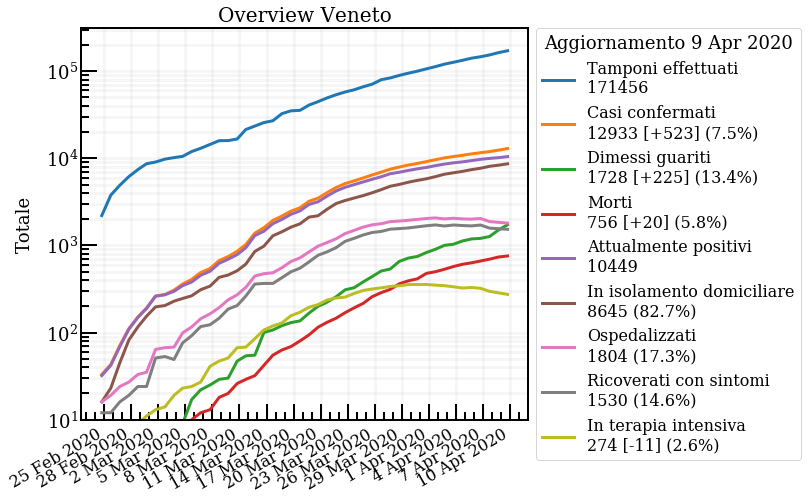

In [581]:
for regione in regioni['region'].unique():
    overview(regione, 'Overview '+regione)

# 2D Trail Plots
Tracciamento dell'evoluzione dei dati (due variabili) tramite scie di punti in grafici 2D.
L'evoluzione dei singoli parametri e' proiettata nei pannelli inferiore e sinistro.

**Come interpretare il grafico:**
* Punti piu' trasparenti corrispondono a giorni precedenti
* La coppia di valori alla data attuale e' mostrata da un punto colorato (zero trasparenza)
* Una maggiore distanza fra i punti (lungo uno degli assi o entrambi) indica una maggiore rapidita' di evoluzione del dato su base giornaliera.
* I valori numerici indicano il valore assoluto raggiunto e l'aumento giornaliero (tra parentesi).


## Casi confermati - Morti

In [582]:
def guideline(ax, xlim=(0,1), ylim=(0,1), m=1, label=''):
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    ax.plot((0,xmax), (0,m*xmax), ls='--', lw=1, color='silver', zorder=-100)

    mplot = (ymax-ymin)/(xmax-xmin)
    if m < mplot:
        coord = [0.85*xmax, 0.85*xmax*m]
    else:
        coord = [0.85*ymax/m, 0.85*ymax]
    label = '%.f%s ' % (m*100, '%') + label
    ax.text(coord[0], coord[1], label, color='silver', fontsize=12, rotation=np.rad2deg(np.arctan(m/mplot)), ha='center', va='center', backgroundcolor='w', zorder=-100)

def trailplot(regions, ndays, varx, vary, xlabel, ylabel, xlim, ylim, guidelines, gl_label):
    sorted_df = data[data.region.isin(regions)][data.date==lastday].sort_values(varx)
    regions = sorted_df.region.unique()

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(14,14))
    grid = plt.GridSpec(2, 3, hspace=0., wspace=0.)
    ax = fig.add_subplot(grid[:-1, 1:])
    y_ax = fig.add_subplot(grid[:-1, 0], xticks=[], sharey=ax)
    x_ax = fig.add_subplot(grid[-1, 1:], sharex=ax)
    x_ax.tick_params(axis='y', which='major', labelsize=14)

    # axes
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    y_ax.set_ylabel(ylabel+' per 100 000 abitanti')
    x_ax.set_xlabel(xlabel+' per 100 000 abitanti')

    # mortality guidelines
    for m in guidelines:
        guideline(ax=ax, xlim=xlim, ylim=ylim, m=m, label=gl_label)

    # plot curves
    days = np.arange(1,ndays)
    mk = 'o'
    ms=100
    #dummy points
    #x_ax.scatter(0,'',label='', color='w')
    y_ax.scatter('',0,label='', color='w')

    cmap = plt.get_cmap('nipy_spectral')
    for i,reg in enumerate(regions):
        color = cmap(i/len(regions))
        df = data[data.region==reg]
        pop = df['population'].iat[0]
        #ax.scatter(df[varx].iat[-1]/pop*1e5, df[vary].iat[-1]/pop*1e5, label='', color=color, marker=mk, s=ms)
        #x_ax.scatter(x,state,label='', color=color, marker=mk, s=ms, alpha=alpha)
        #y_ax.scatter(state,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
        for day in list(reversed(days)):
            x = df[varx].iat[-day]/pop*1e5 # total value 'day' ago
            y = df[vary].iat[-day]/pop*1e5
            alpha = 1./day
            ax.scatter(x,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
            x_ax.scatter(x,reg,label='', color=color, marker=mk, s=ms, alpha=alpha)
            y_ax.scatter(reg,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
        x_ax.text(x+0.03*xlim[1], reg, '%d (+%d)' % (df[varx].iat[-1], df['new_'+varx].iat[-1]), ha='left', va='center', fontsize=12)
        y_ax.text(reg, y+0.03*ylim[1], '%d (+%d)' % (df[vary].iat[-1], df['new_'+vary].iat[-1]), ha='center', va='bottom', fontsize=10, rotation=90)

    #ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    x_ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    #ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    y_ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')

    #legend
    leg = ax.legend(loc='upper left', frameon=True, ncol=1, 
                     title='COVID-19 | Ultimi %d giorni\n(Aggiornato %s)' % (ndays, lastday.strftime('%-d %b %Y')))
    #leglabels_style()

    plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
No handles with labels found to put in legend.


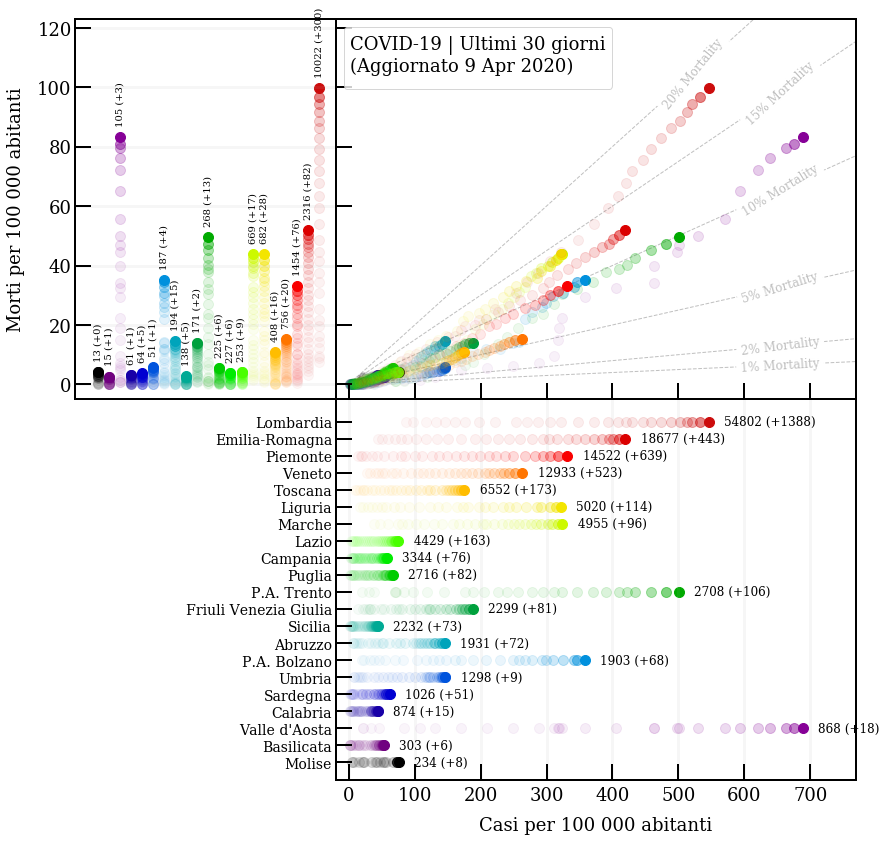

In [583]:
# Casi vs Morti
trailplot(regions=regioni.region.unique(), ndays=30,
          varx='cases', vary='deaths', xlabel='Casi', ylabel='Morti',
          xlim=(-20,770), ylim=(-5,123), guidelines=[0.2,0.15,0.1,0.05,0.02,0.01], gl_label='Mortality',
         )

## Tamponi effettuati - Casi di positivita' 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
No handles with labels found to put in legend.


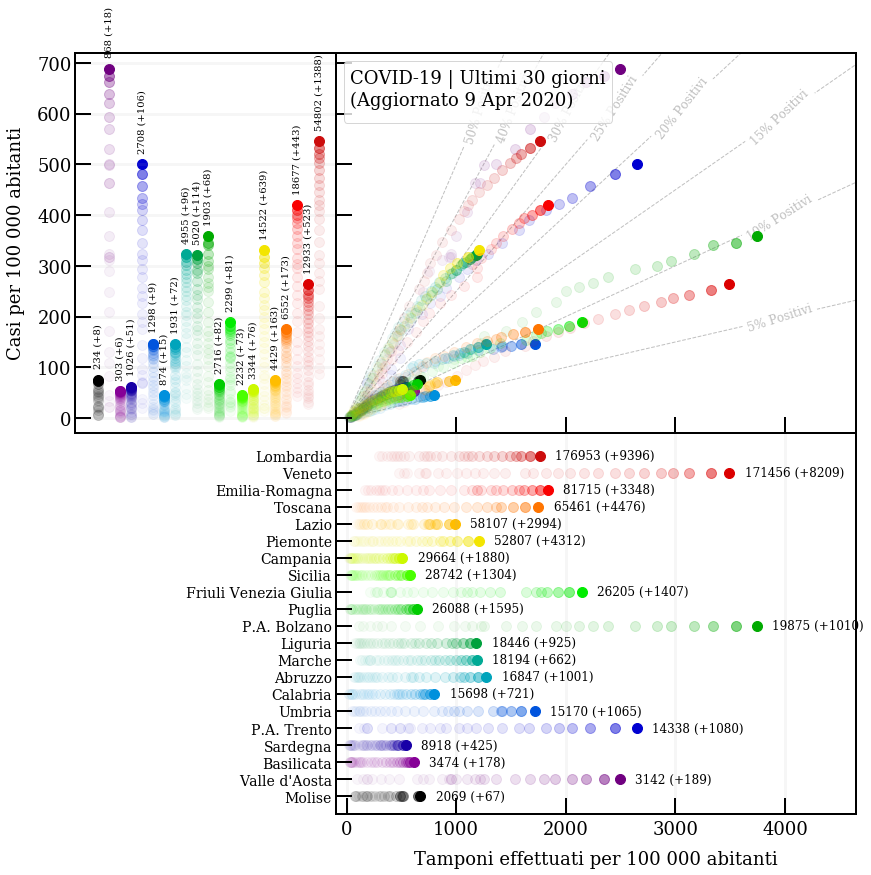

In [590]:
# Casi vs Tamponi
trailplot(regions=regioni.region.unique(), ndays=30,
          varx='tests', vary='cases', ylabel='Casi', xlabel='Tamponi effettuati',
          xlim=(-100,4650), ylim=(-30,720), guidelines=[0.5,0.4,0.3,0.25,0.2,0.15,0.1,0.05], gl_label='Positivi',
         )

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
No handles with labels found to put in legend.


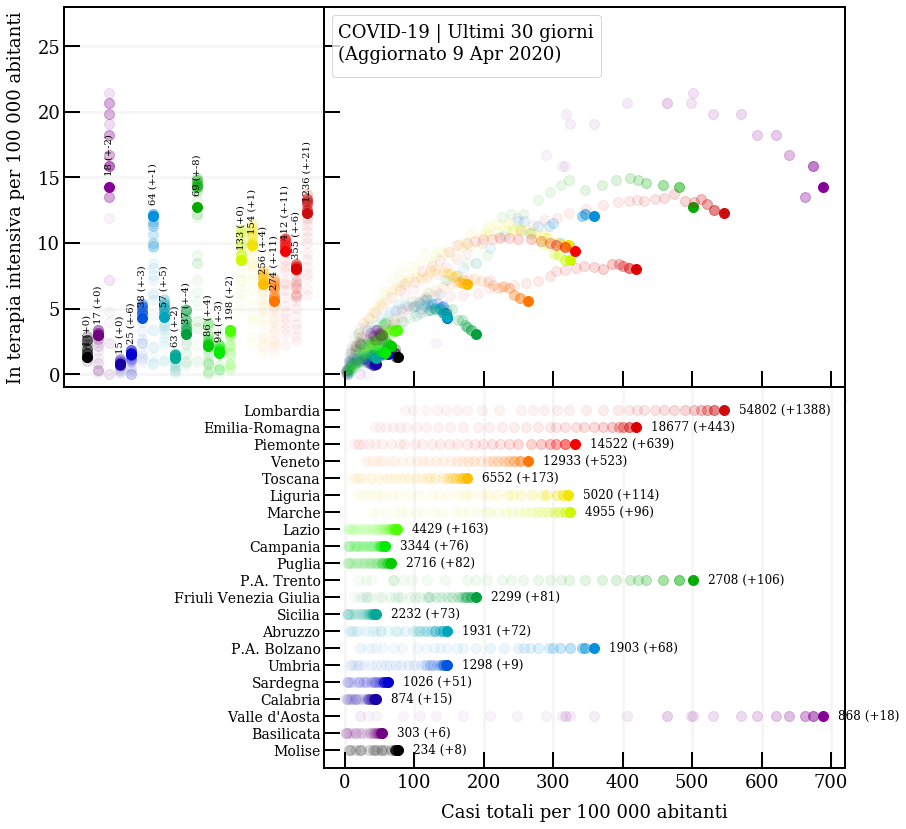

In [585]:
# Casi vs Tamponi
trailplot(regions=regioni.region.unique(), ndays=30,
          varx='cases', vary='terapia_intensiva', ylabel='In terapia intensiva', xlabel='Casi totali',
          xlim=(-30,720), ylim=(-1,28), guidelines=[], gl_label='',
         )

## Casi positivi - Casi in terapia intensiva
Evoluzione dei casi positivi (totale) e ricoveri in terapia intensiva (attuale) per regione.

**Effetto della neutralizzazione del virus:**
* Nessun avanzamento lungo l'asse dei casi totali
* Caduta dei punti verso lo zero dell'asse dei casi in terapia intensiva

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


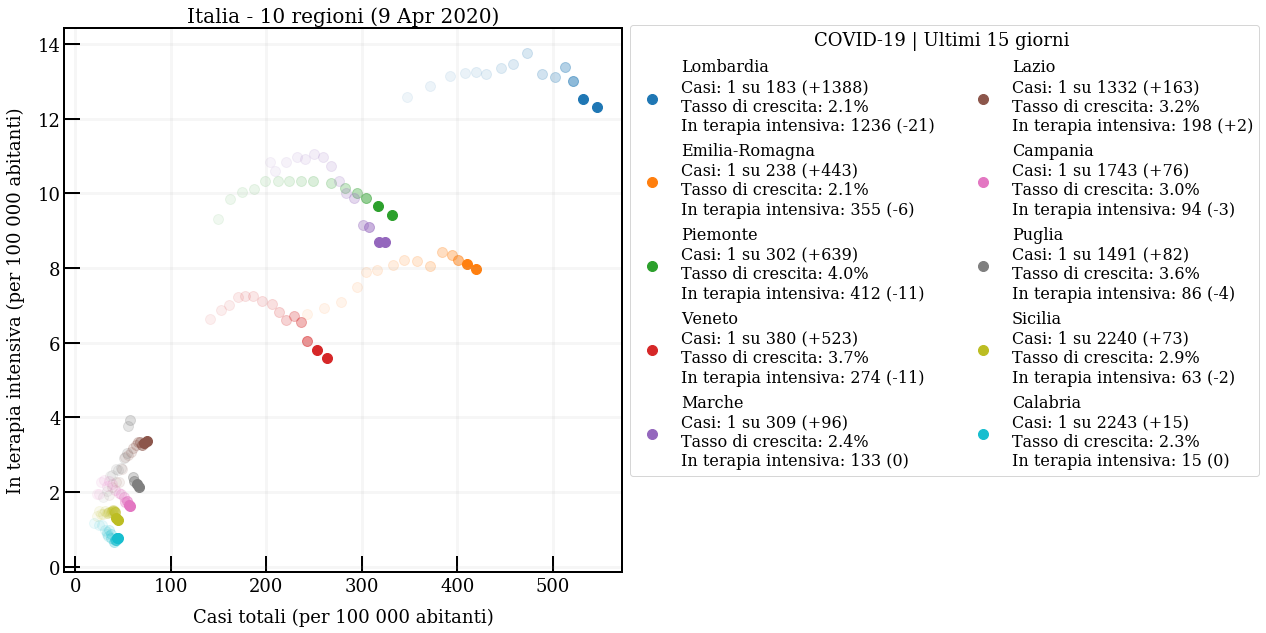

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


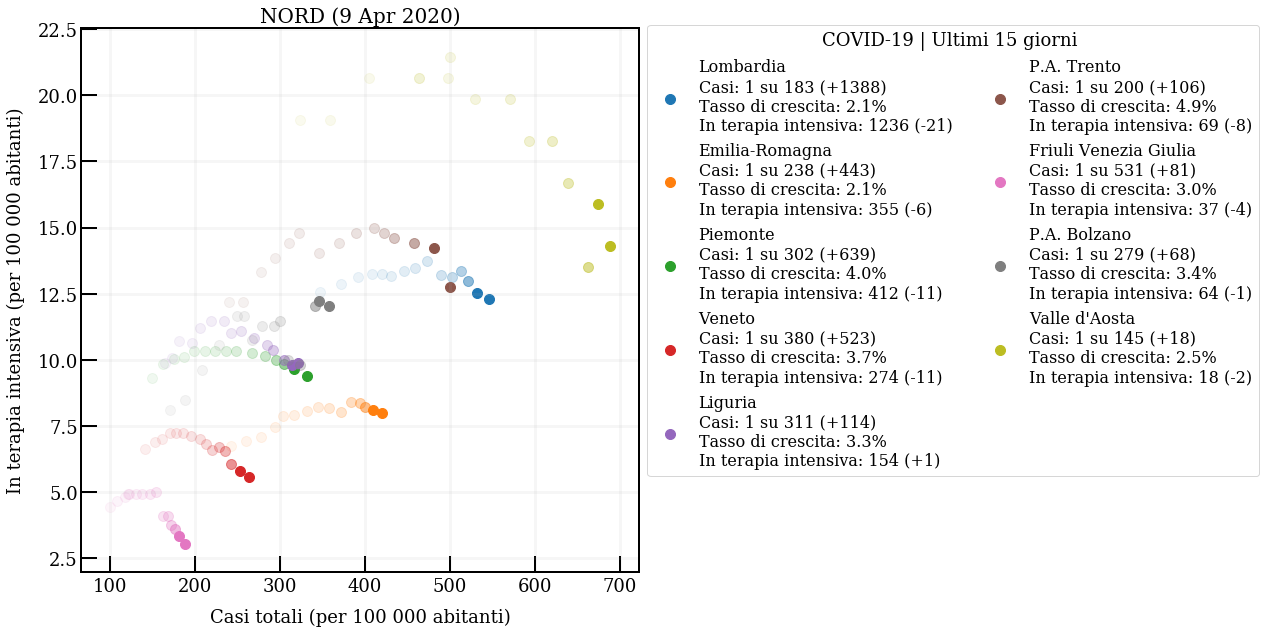

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


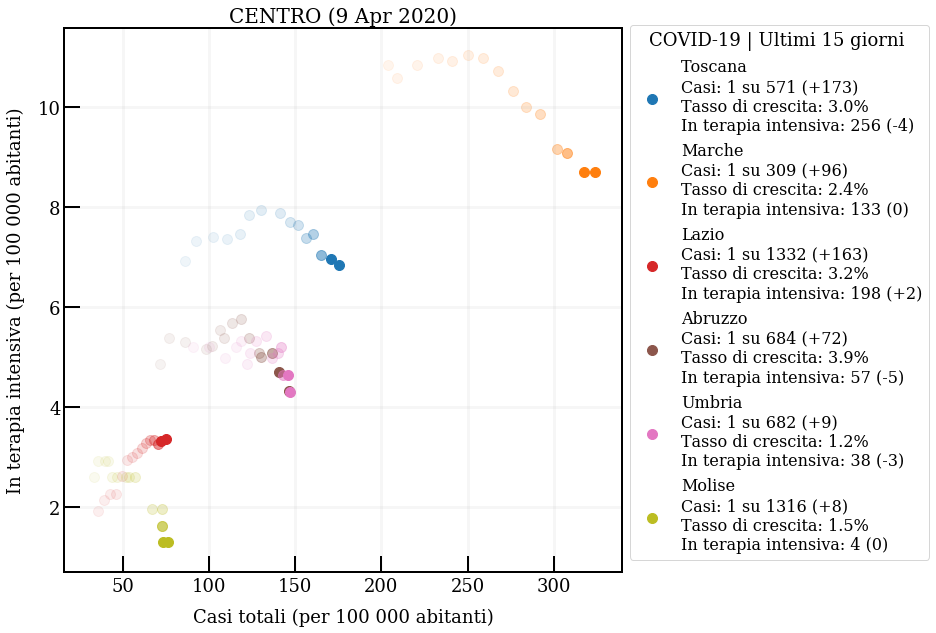

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


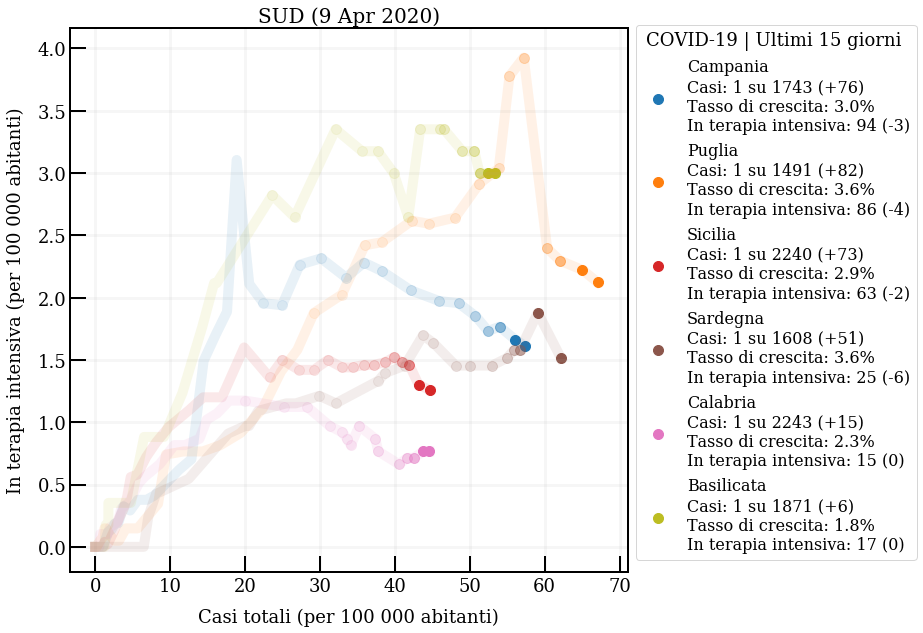

In [586]:
def pointevo_cases_icu(regions, dayspan, title='', line=False):
    vary = 'terapia_intensiva'
    varx = 'cases'
    regions = sorted_set(regions, 'cases')
    N = len(regions)
    cm = plt.get_cmap('tab10')

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    # plot curves
    ndays = dayspan
    days = np.arange(1,ndays)
    mk = 'o'
    ms=100

    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df.population.iat[0]
        totx = df[varx].iat[-1]
        toty = df[vary].iat[-1]
        normalization = pop/1e5

        lb = '%s\nCasi: 1 su %.f (+%.f)' % (reg, pop/df.cases.iat[-1], df.new_cases.iat[-1])
        lb = lb + '\nTasso di crescita: %.1f%s' % (df.cases_delta3.iat[-1]*100, '%')
        sign = '+'
        if df.new_terapia_intensiva.iat[-1]<=0: sign=''
        lb = lb + '\nIn terapia intensiva: %d (%s%.f)' % (df.terapia_intensiva.iat[-1], sign, df.new_terapia_intensiva.iat[-1])
        if line:
            ax.plot(df[varx]/normalization, df[vary]/normalization, label='', color=cm(1.*i/N), lw=10, alpha=0.1)
        ax.scatter(df[varx].iat[-1]/normalization, df[vary].iat[-1]/normalization, label=lb, color=cm(1.*i/N), marker=mk, s=ms)

        for day in list(reversed(days)):
            x = df[varx].iat[-1-day]/normalization # total value 'day' ago
            y = df[vary].iat[-1-day]/normalization
            alpha = 1/day
            ax.scatter(x,y,label='', color=cm(1.*i/N), marker=mk, s=ms, alpha=alpha)

    plt.ylabel('In terapia intensiva (per 100 000 abitanti)')
    plt.xlabel('Casi totali (per 100 000 abitanti)')
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    
    #plt.text(0, ax.get_ylim()[1]*0.95, title, fontsize=24, horizontalalignment='left')
    #legend
    leg = plt.legend(loc='upper left', ncol=int(N/7)+1, bbox_to_anchor=(1.,1.02), 
                     title='COVID-19 | Ultimi %d giorni ' % ndays)
    plt.title(title+' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)

    plt.show()
    
    
regions = ['Lombardia', 'Emilia-Romagna', 'Marche', 'Piemonte', 'Veneto', 'Puglia', 'Lazio', 'Sicilia', 'Calabria', 'Campania']
pointevo_cases_icu(regions,15, 'Italia - 10 regioni', 0)
regions = nord
pointevo_cases_icu(regions,15, 'NORD', 0)
regions = centro
pointevo_cases_icu(regions,15, 'CENTRO', 0)
regions = sud
pointevo_cases_icu(regions,15, 'SUD', 1)